In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
#prediction library
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#Classificaion library
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [6]:
#the csv file is sometimes not well separated when there is more than one author, have to correct it manualy
df = pd.read_csv("C:/Users/Ben/GoodReadsProject/books.csv",sep=",",index_col="bookID")

In [7]:
#First look at all the variables
print(list(df))
#There is a space in some column name
# remove special character
df.columns = df.columns.str.replace(' ', '')
list(df)

['title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher']


['title',
 'authors',
 'average_rating',
 'isbn',
 'isbn13',
 'language_code',
 'num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher']

In [8]:
#Droping the 2 uniaue identifiers, we won't have use of them
df = df.drop(columns=["isbn","isbn13"]) 

In [9]:
#Note : After trying a linear regression we will change our approach to a classification. 
#We have a problem at the start wich are the data by themself. most of the average rating are very concentrated around the mean. 
#therefore we don't have enough lower ratings.The model can't be good at predicting bad ratings. 
#We are going to regroup ratings in 3 category : bad / medium / good 
#We will base the bining o the distribution of the series

In [10]:
df.describe()
#We see that num pages ratings and text review are float variable, this is not possible, we will force those variable into int

average_rating     num_pages  ratings_count  text_reviews_count
count    11127.000000  11127.000000   1.112700e+04        11127.000000
mean         3.933631    336.376921   1.793641e+04          541.854498
std          0.352445    241.127305   1.124794e+05         2576.176608
min          0.000000      0.000000   0.000000e+00            0.000000
25%          3.770000    192.000000   1.040000e+02            9.000000
50%          3.960000    299.000000   7.450000e+02           46.000000
75%          4.135000    416.000000   4.993500e+03          237.500000
max          5.000000   6576.000000   4.597666e+06        94265.000000

In [11]:
df.describe(include = ['O']) # We can see that the title isn't a unique value and that some authors have written more than one book 
#but be carefull because python look for exactly the same value, there could be misspellings and errors. There's also more than one authors sometimes
#Also some authors have written several books; we should look if the number of book written by an authors 
#Could have an impact on the average ratings of those books. 

#Analysis : 

# 1) look into the books with the same name if there is a pattern or something odd
#--> We note that for a same title the ratings are averaged but the explanatory variables are different,
#compute the mean per title of num pages, average rating, total ratings count and min of date.
#1bis) Look if there is any pattern with name of the books (number of words ect..)
#2) Look into the average rating per language code
#2) find a way to look if the number of books written by an authors is correlated with the average rating of his books 
#3) find a way to signal if the book has been written by more than one authors (if there is a "/" in the string )
#and Look if co written book are rated differently
#4) Look if an authors has an already good book and see if it has an impact on the overall, maybe use a dummy to separate good
#authors from bad one
#5) Look into the rating/review count
#--> We only keep data we at leat 100 review (First quartile) to train our model on data we can trust. 
#6) Explore the publication date series


title       authors language_code publication_date  \
count                    11127         11127         11127            11127   
unique                   10352          6643            27             3679   
top     The Brothers Karamazov  Stephen King           eng       10/01/2005   
freq                         9            40          8911               56   

       publisher  
count      11127  
unique      2292  
top      Vintage  
freq         318

In [12]:
df.describe()
df.dtypes

title                  object
authors                object
average_rating        float64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

In [182]:
# Generate the profile report with Pandas Profiling
profile = ProfileReport(
    df,
    title="summarization of data"
)

In [183]:
# Generate the dataset profile
# This is a nice and simple way to document the data
profile.to_notebook_iframe()

#All the quant variable have a relatively low correlation with average rating.
#Text review and rating counts are strongly correlated together (multicolinearity, I will keep only one of this 2 column)
#Average ratings is normaly distributed around 3.93. We can see outliers around 0. furthermore the big majority of the 
#distribution is beetween 3 and 4.5. 
#We can see there is a # in the title for books in a series ie : Harry Potter 
#Some books have a small numbers of rating, we will choose to drop those row because it is hard to trust those ratings 
#We see the title is not a unique identifier, we will look further into this
#For the publication date, we will keep only the year and see if there is any pattern inside the data

#First thing we will treat the title variable, some books appear more than once, based on our analysis we will keep only one 
#row per title and average the rows per title. We will keep as information if the book reappear more than once.
#It could indicate if a book is republished it means it is a good book.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
#1)look into the books with the same name if there is a pattern or something odd
#we look first with The Brothers Karamazov, there is 9 occurences
TheBrothersKaramazovBooks = df.loc[df['title'] == 'The Brothers Karamazov']
TheBrothersKaramazovBooks
#Seems all the books have exactly the same rating but different authors/num of page and ratings + review .. Should I drop those data ?

#Let's look at the dataset of non unique title

NonUnicTitle = df[df.duplicated(subset=['title'],keep=False)]
NonUnicTitle.sort_values(by='title', ascending=False) 

#When there's more than one row for a book title, it looks like the books has been republished with a different publisher 
#or under a different version.
#The rating has been averaged in most case (the rating is the same for all the rows with the same title). 
#In Salem's lot, it's not the case, we need to average the rating per title and ponderate this mean per rating count of the version.
#Lets look at the basic stats of the data set

#NonUnicTitle.describe()
#At first sight, we don't see any impact on the overall average rating, only the std is smaller 
#The republished books migth be more concentrated around the mean
#Let's check books and there occurances, maybe if a book is published a lots of times the average ratings gonna raise



title                         authors  \
bookID                                                                         
12703                      Wuthering Heights      Emily Brontë/Alice Hoffman   
6184                       Wuthering Heights                    Emily Brontë   
9763    Wild Swans: Three Daughters of China                      Jung Chang   
1848    Wild Swans: Three Daughters of China                      Jung Chang   
44595                      Wide Sargasso Sea                       Jean Rhys   
...                                      ...                             ...   
19135                           'Salem's Lot        Stephen King/Ron McLarty   
5419                            'Salem's Lot                    Stephen King   
5415                            'Salem's Lot                    Stephen King   
5414                            'Salem's Lot        Stephen King/Ron McLarty   
5413                            'Salem's Lot  Stephen King/Jerry N. Uelsmann   

        average_rating language_code  num_pages  ratings_count  \
bookID                                                           
12703             3.85           eng        322           1898   
6184              3.85           eng        279           2155   
9763              4.26           eng        666           1832   
1848              4.26           eng        562          73572   
44595             3.58         en-US        168            878   
...                ...           ...        ...            ...   
19135             4.02         en-US          0             56   
5419              4.02         en-US        427            178   
5415              4.02           eng        405           1039   
5414              4.02           eng         17            227   
5413              4.25           eng        594          84123   

        text_reviews_count publication_date               publisher  
bookID                                                               
12703                  201        3/02/2004         Signet Classics  
6184                   182        1/13/2007           Penguin Books  
9763                   214        4/05/2004        Harper Perennial  
1848                  4280        8/12/2003         Simon  Schuster  
44595                   79        4/26/2001        Penguin Classics  
...                    ...              ...                     ...  
19135                    5        1/19/2004  Simon & Schuster Audio  
5419                    35       11/13/1979                  Signet  
5415                   130       10/17/1975               Doubleday  
5414                    54        1/19/2004  Simon & Schuster Audio  
5413                   571       11/01/2005               Doubleday  

[1262 rows x 9 columns]

C:\Users\Ben\AppData\Local\Temp\ipykernel_3904\3868177457.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  rating = df.average_rating[:20]


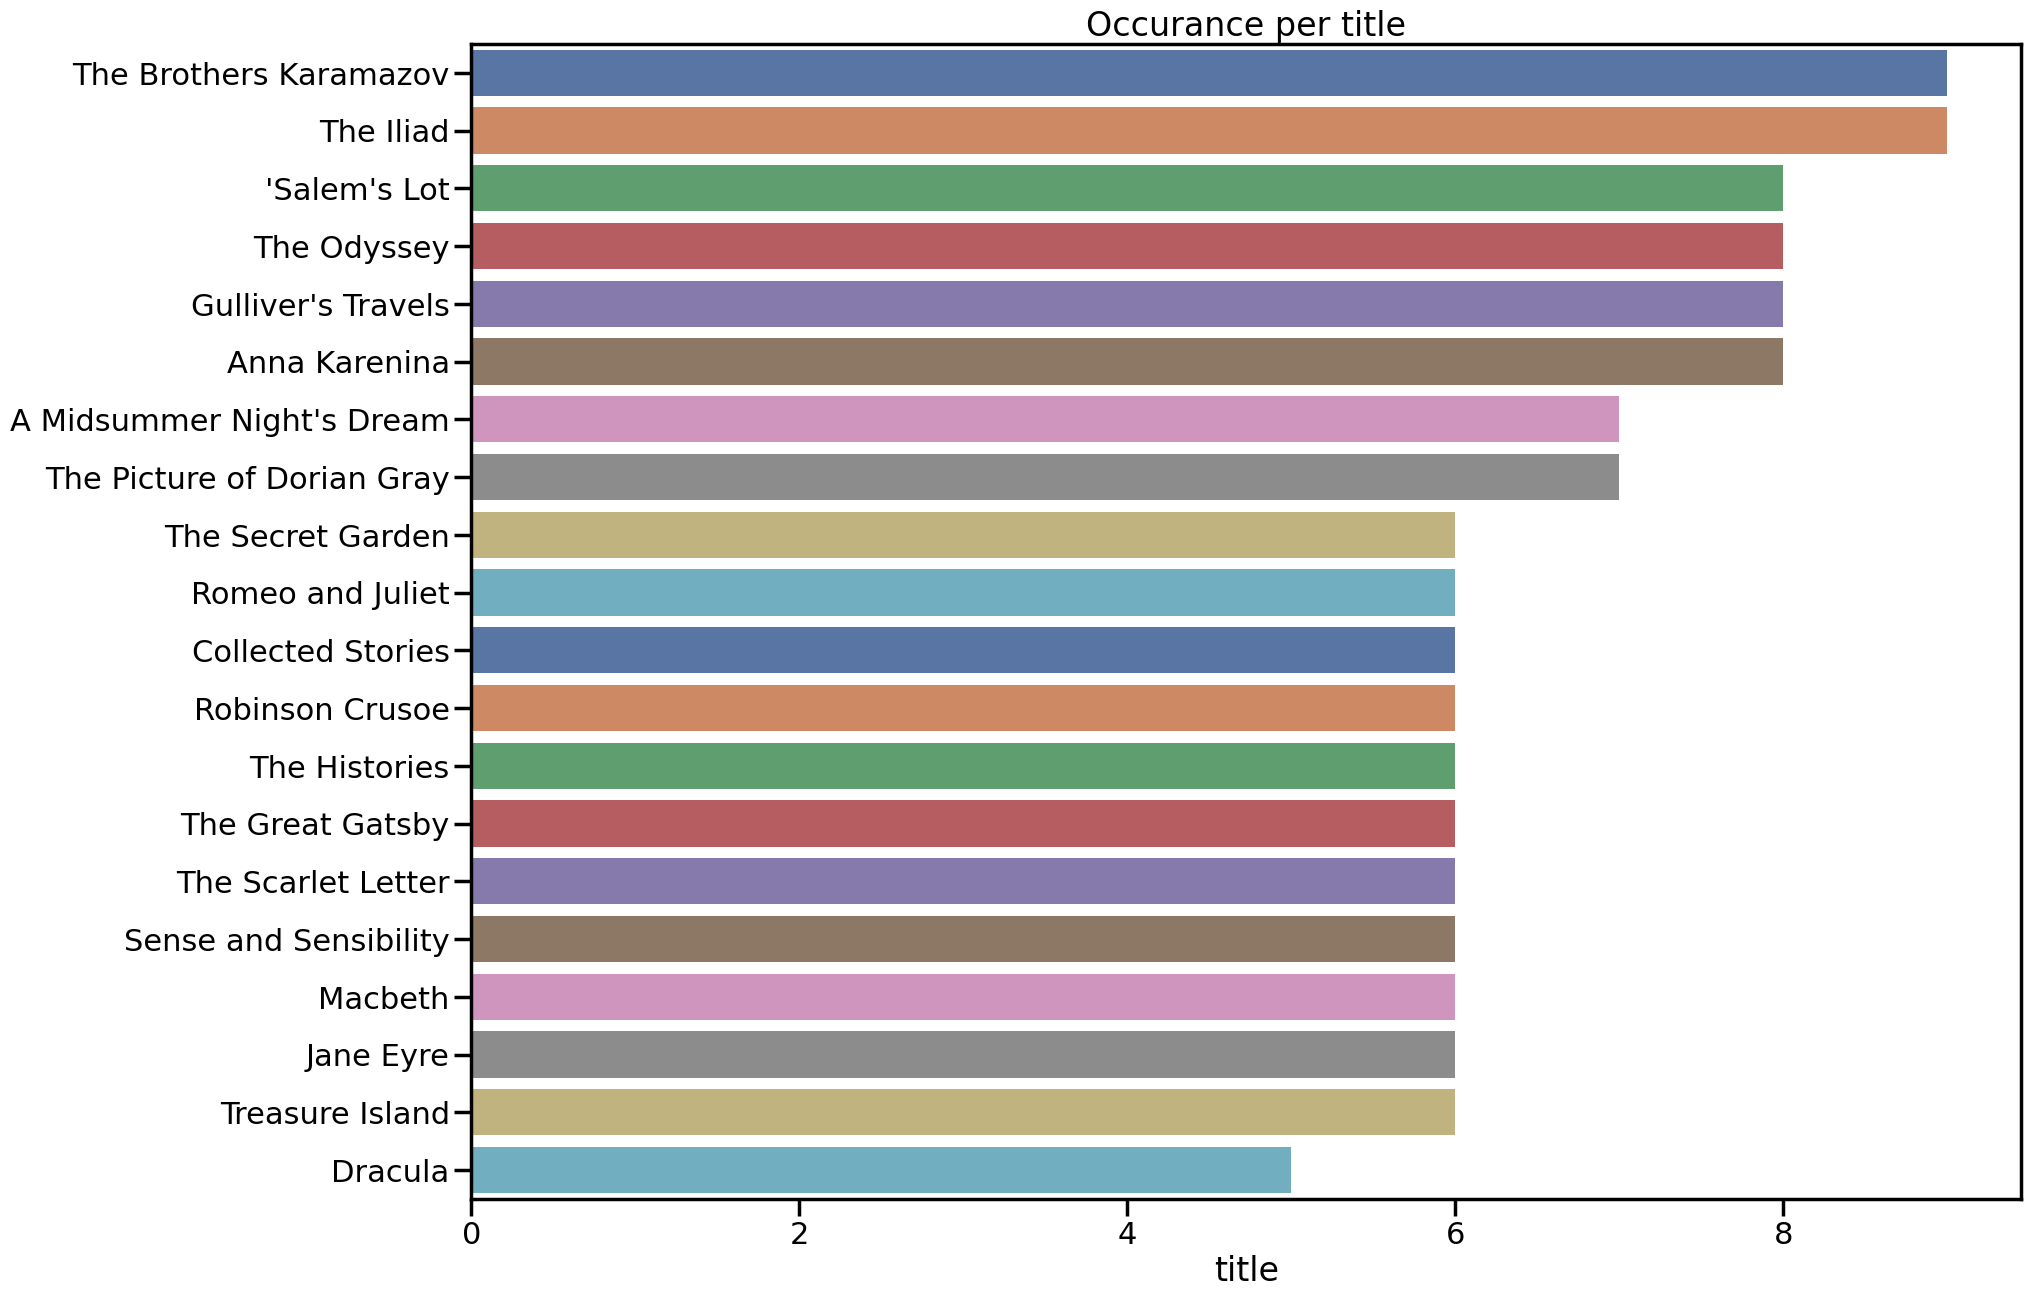

Average Ratings by Occur:
 Occur
9    4.090000
5    4.017200
7    4.010000
4    3.969839
2    3.940481
1    3.931882
3    3.931441
6    3.911970
8    3.862812
Name: average_rating, dtype: float64


1    9865
2     686
3     222
4     124
5     100
6      66
8      32
9      18
7      14
Name: Occur, dtype: int64

In [13]:
#Here the 20 first books per occurence count
sns.set_context('poster')
plt.figure(figsize=(20,15))
book = df['title'].value_counts()[:20]
rating = df.average_rating[:20]
sns.barplot(x=book, y=book.index, palette= 'deep').set(title='Occurance per title')
plt.show()

#Lets look if higher the occurances, higher the rating, I will add the column "Occur"to the dataset 
df['Occur'] = df.groupby('title')['title'].transform('size')

#plt.scatter(df["Occur"],df["average_rating"])

#visually we don't observe the last hypothesis but the std seems smaller and the distribution more concentrated around the mean.

#plt.figure(figsize=(20,10))
#sns.boxplot(x=df.rating_class,y=df.Occur)
#plt.show()

# Group books by occur and compute average ratings
by_Occur = df.groupby('Occur')['average_rating'].mean()
by_Occur = by_Occur.sort_values(ascending=False)
print('Average Ratings by Occur:\n', by_Occur)

df.Occur.value_counts() 
#We can definitly see that the distribution of republished books is more concentrated around the mean. But there's some categories
#where the number of books are really low -->
#I will create a dummy to mark the books that has been republished



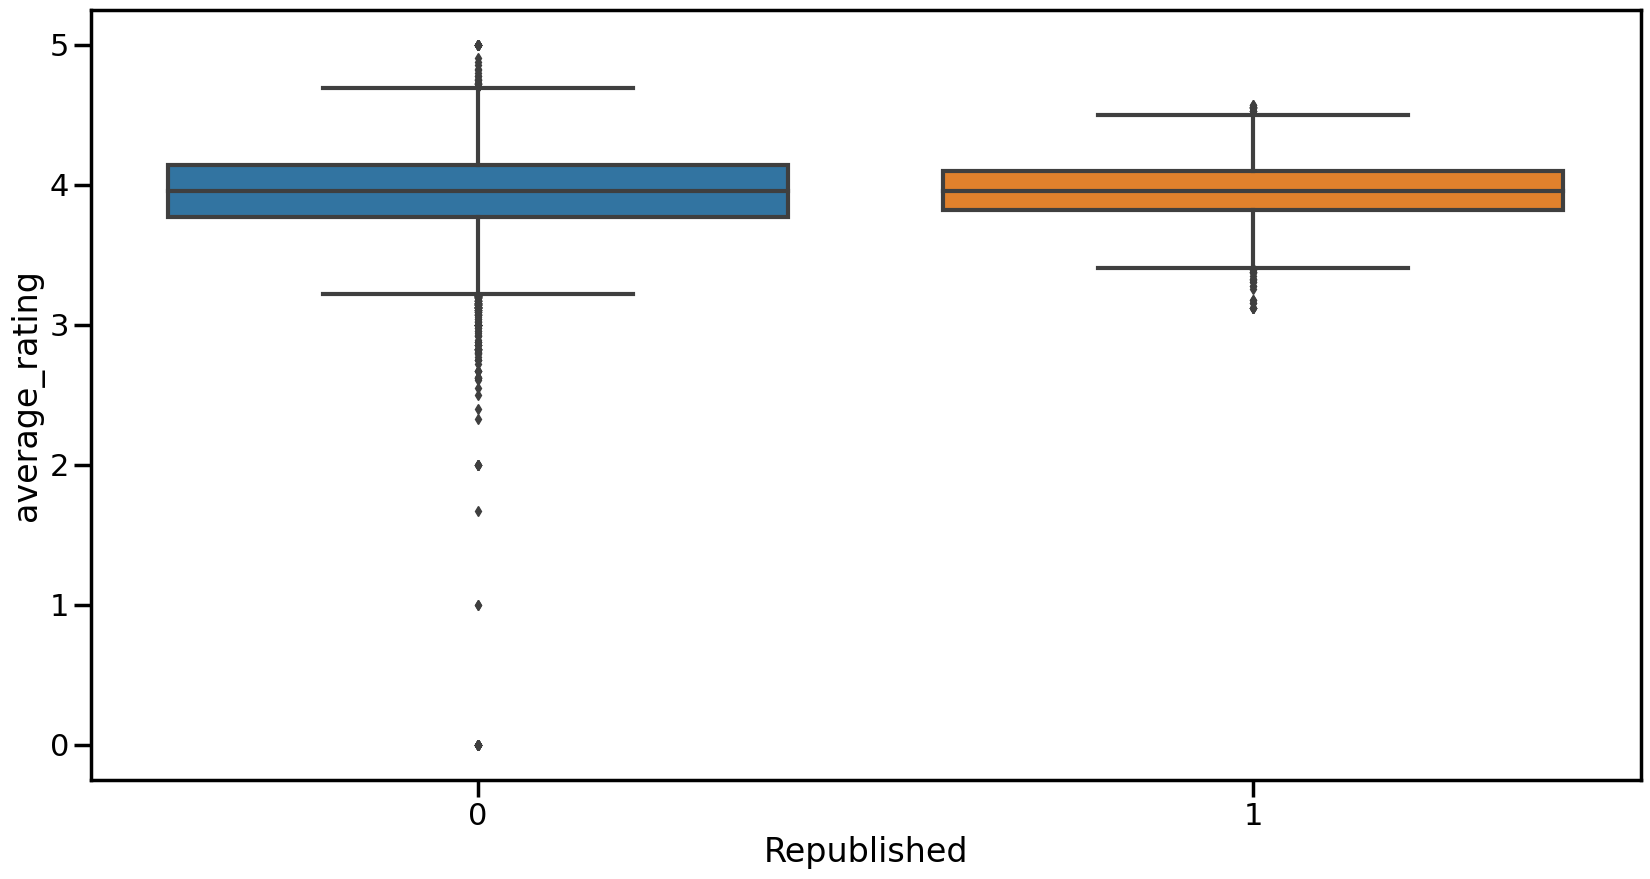

0    9865
1    1262
Name: Republished, dtype: int64

In [14]:
#Finaly we will keep as information if the books has been published more than once and see if it as an impact on the rating
#Lets create one dummy to say if the book has been republished or has more than one occurance

df['Republished'] = np.where(
    df['Occur'] == 1, 0, 1) 


plt.figure(figsize=(20,10))
sns.boxplot(x=df.Republished,y=df.average_rating)
plt.show()


df.Republished.value_counts() 

#We confirm that republished books have a smaller std. The dataset is also unbalanced. 

In [15]:
#Per title transformation : keep one row per title so we need to average the values per title 
#Here are the transformation to compute the total ratings count; the average num of pages and the average year of publication per book, 
#and delete all the duplicates.

df['Avg_num_pages'] = df.groupby('title')['num_pages'].transform('mean')
df['Avg_num_pages'] = df['Avg_num_pages'].round(decimals = 0)

#Because the rating is already an average of all the rating for one book, 
#we are keeping only one row per title. We will average the year per title to keep the information (like for num_pages) 
#and then delete the row. 

#Year of first publication :

#first we  extract the year from the column date and convert it to int
df['year'] = df['publication_date'].str.slice(start=-4)
df['year'] = df['year'].astype(int)

#Then keep the year of first publication per book
df['year_of_first_publication'] = df.groupby('title')['year'].transform('min')
df['year_of_first_publication'] = df['year_of_first_publication'].astype(int)

#The sum of the ratings count per title 
# This will allow us to then exclude the books with less 100 ratings in total
df['Sum_Ratings_count'] = df.groupby('title')['ratings_count'].transform('sum')
df['Sum_TextReview_count'] = df.groupby('title')['text_reviews_count'].transform('sum')
#Average rating per book's title :
#We note that all the ratings for Salem's lot are not the same, we will compute the average rating per title which we will 
#ponderate per ratings_count 

df['Ponderate_avg_ratings_per_row'] = df["average_rating"]*(df["ratings_count"]/ df["Sum_Ratings_count"])
df['Ponderate_avg_ratings_per_book'] = df.groupby('title')['Ponderate_avg_ratings_per_row'].transform('sum').round(decimals = 2)

#Droping useless column now 
#df = df.drop(columns=["Ponderate_avg_ratings_per_row"]) 

#Let's check our new column
#1-Ponderate_avg_ratings_per_book / 2-year_of_first_publication / -3 Sum_Ratings_count / -4 Avg_num_pages

SalemsLot = df.loc[df['title'] == "'Salem's Lot"]
(SalemsLot.head(10))

#We can now drop all the duplicate rows, be carefull we need to not keep the raw

df_sorted = df.sort_values(by='Ponderate_avg_ratings_per_row', ascending=False)
df_unique = df_sorted.drop_duplicates(subset=['title'], keep='first')

#df_Unique = df.drop_duplicates(subset=['title'])
#print(df_Unique.describe(include = ['O']))

#df_Unique.head()

df_unique.describe()

average_rating     num_pages  ratings_count  text_reviews_count  \
count    10352.000000  10352.000000   1.035200e+04        10352.000000   
mean         3.932738    334.415185   1.919325e+04          576.184699   
std          0.359091    238.382978   1.164835e+05         2666.850317   
min          0.000000      0.000000   0.000000e+00            0.000000   
25%          3.770000    194.000000   1.100000e+02            9.000000   
50%          3.960000    296.000000   8.560000e+02           50.000000   
75%          4.140000    411.000000   5.729000e+03          261.000000   
max          5.000000   6576.000000   4.597666e+06        94265.000000   

              Occur   Republished  Avg_num_pages          year  \
count  10352.000000  10352.000000   10352.000000  10352.000000   
mean       1.074865      0.047044     333.250097   2000.207883   
std        0.422873      0.211743     237.432508      8.169129   
min        1.000000      0.000000       0.000000   1900.000000   
25%        1.000000      0.000000     193.000000   1998.000000   
50%        1.000000      0.000000     295.000000   2003.000000   
75%        1.000000      0.000000     410.000000   2005.000000   
max        9.000000      1.000000    6576.000000   2020.000000   

       year_of_first_publication  Sum_Ratings_count  Sum_TextReview_count  \
count               10352.000000       1.035200e+04          10352.000000   
mean                 1999.962519       1.927921e+04            582.420305   
std                     8.413669       1.170049e+05           2688.075959   
min                  1900.000000       0.000000e+00              0.000000   
25%                  1998.000000       1.110000e+02              9.000000   
50%                  2002.000000       8.615000e+02             51.000000   
75%                  2005.000000       5.786250e+03            264.000000   
max                  2020.000000       4.597666e+06          94265.000000   

       Ponderate_avg_ratings_per_row  Ponderate_avg_ratings_per_book  
count                   10275.000000                    10352.000000  
mean                        3.926274                        3.913516  
std                         0.330073                        0.450779  
min                         1.000000                        0.000000  
25%                         3.760000                        3.770000  
50%                         3.950000                        3.960000  
75%                         4.130000                        4.140000  
max                         5.000000                        5.000000

In [16]:
#Test of the result for one book
Covers = df_unique.loc[df_unique['title'] == "1000 Record Covers"]
(Covers.head(10))

title                                    authors  \
bookID                                                                  
576     1000 Record Covers  Michael Ochs/Patrick Javault/Ulrike Wasel   

        average_rating language_code  num_pages  ratings_count  \
bookID                                                           
576               3.85           mul        575            288   

        text_reviews_count publication_date publisher  Occur  Republished  \
bookID                                                                      
576                     31        5/15/2005   Taschen      1            0   

        Avg_num_pages  year  year_of_first_publication  Sum_Ratings_count  \
bookID                                                                      
576             575.0  2005                       2005                288   

        Sum_TextReview_count  Ponderate_avg_ratings_per_row  \
bookID                                                        
576                       31                           3.85   

        Ponderate_avg_ratings_per_book  
bookID                                  
576                               3.85

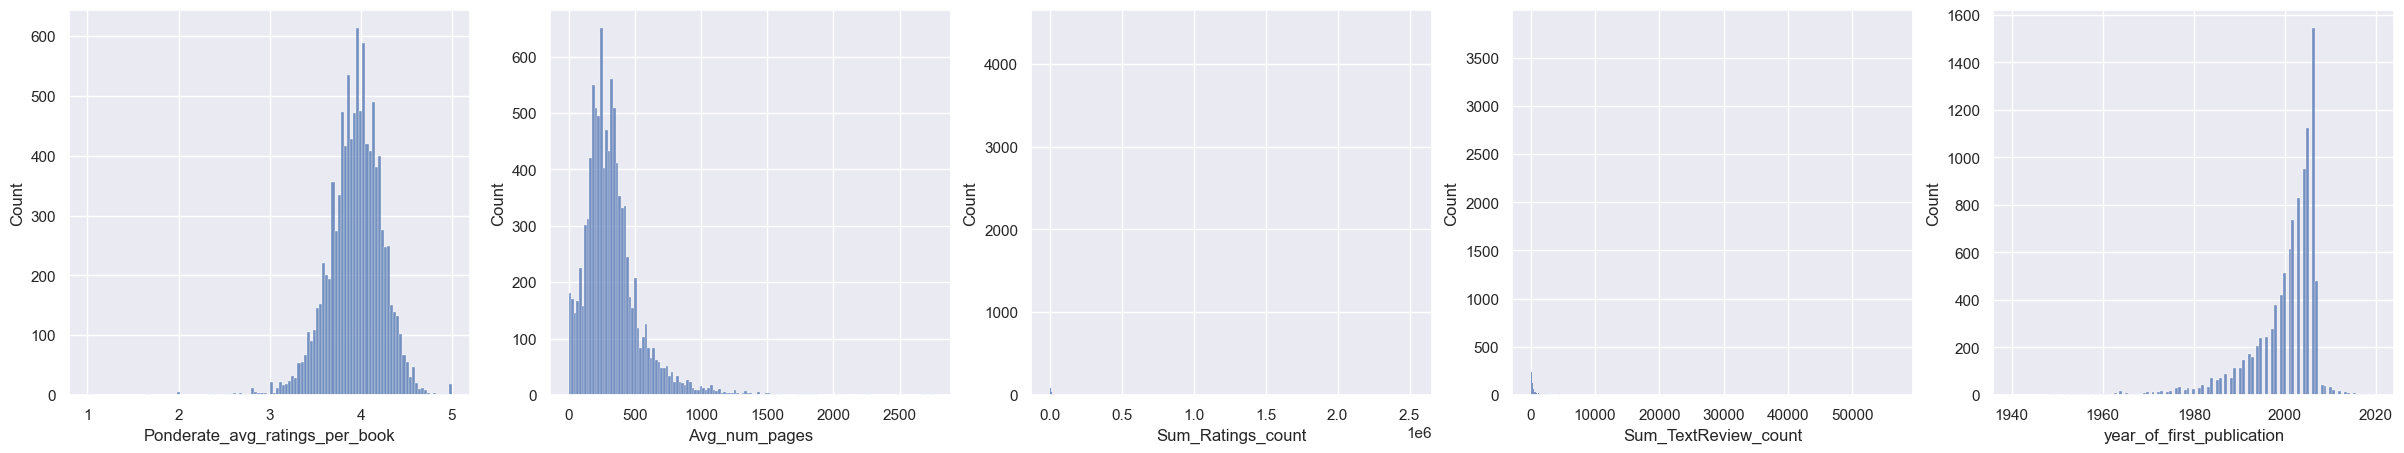

In [138]:
#lets look at the distribution of our numerical variables
#We gonna first extract the year of publication from the date and transform it as a int variable and visualy look at all the distribution


# Select columns to plot
columns_to_plot = ['Ponderate_avg_ratings_per_book', 'Avg_num_pages', 'Sum_Ratings_count', 'Sum_TextReview_count', 'year_of_first_publication']

# Create a figure with subplots
fig, axs = plt.subplots(ncols=len(columns_to_plot), figsize=(30, 5))

# Loop through each column to plot and create a histogram plot
for i, col in enumerate(columns_to_plot):
    sns.histplot(data=df_unique, x=col, ax=axs[i])

# Display the plot
plt.show()

#note : 
#The ratings distribution is normal and higly centered around 3.9. Only a relatively low numbers books have a rating under 3/2
#It is going to be a problem for our model to detect "bad" books. 
#A good distribution would have been centered around 2.5 a normaly distributed
#hard to say anything to ratings count and text review count so far except that the distribution goes around a large number of values
#The Year and num_pages look normally distributed and skewed respectively to the left and to the right.
#We do note a lot of 0 value for ratings count, text review count and num_pages

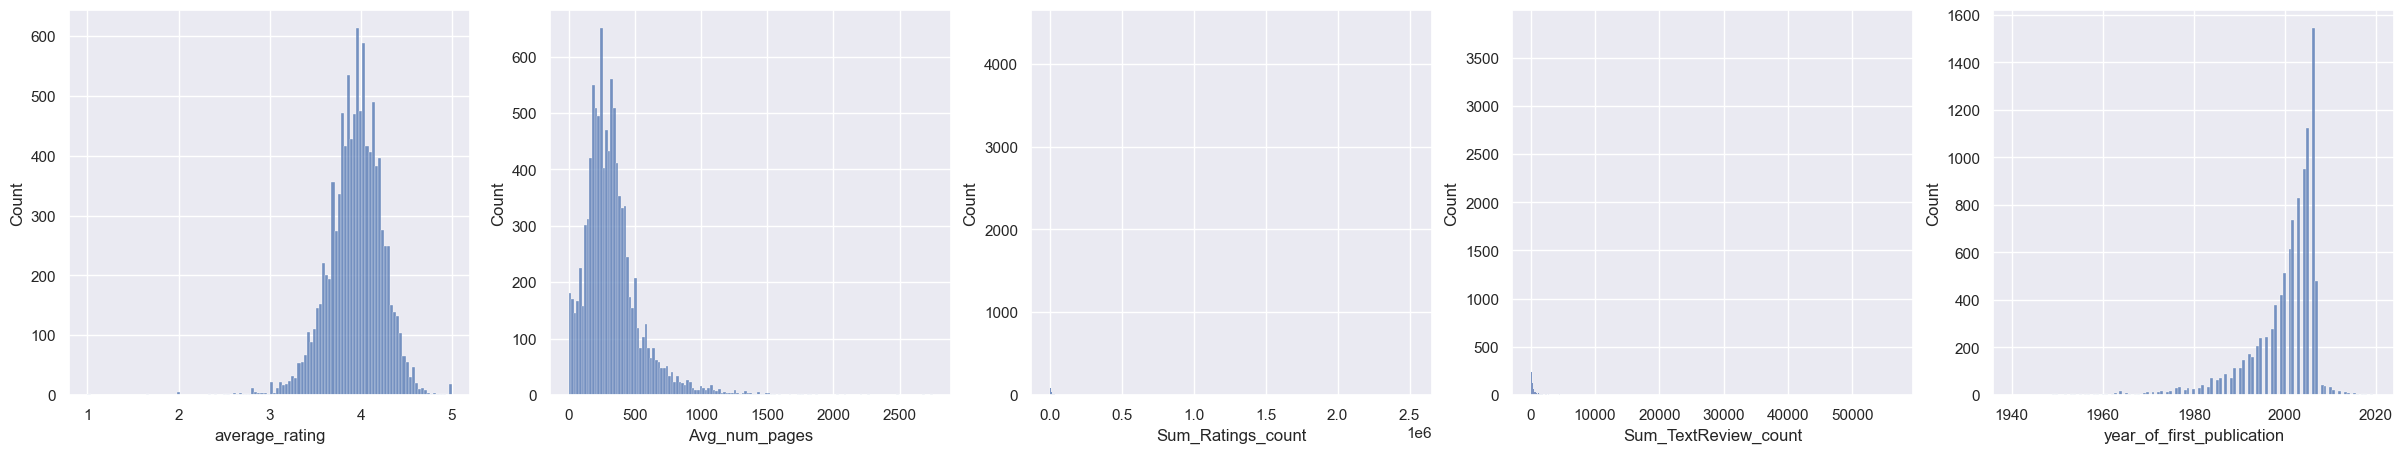

In [140]:
#lets look at the distribution of our numerical variables
#We gonna first extract the year of publication from the date and transform it as a int variable and visualy look at all the distribution


#Year of first publication :

#first we  extract the year from the column date and convert it to int
#df['year'] = df['publication_date'].str.slice(start=-4)
#df['year'] = df['year'].astype(int)

#Some books appear several times with different publication data so will keep the year of first publication per book
#df['year_of_first_publication'] = df.groupby('title')['year'].transform('min')
#df['year_of_first_publication'] = df['year_of_first_publication'].astype(int)


# Select columns to plot
columns_to_plot = ['average_rating','num_pages', 'Ratings_count', 'TextReview_count', 'year_of_first_publication']
# Create a figure with subplots
fig, axs = plt.subplots(ncols=len(columns_to_plot), figsize=(30, 5))

# Loop through each column to plot and create a histogram plot
for i, col in enumerate(columns_to_plot):
    sns.histplot(data=df_unique, x=col, ax=axs[i])

# Display the plot
plt.show()

#note : 
#The ratings distribution is normal and higly centered around 3.9. Only a relatively low numbers books have a rating under 3/2
#It is going to be a problem for our model to detect "bad" books. 
#A good distribution would have been centered around 2.5 a normaly distributed
#hard to say anything to ratings count and text review count so far except that the distribution goes around a large number of values
#The Year and num_pages look normally distributed and skewed respectively to the left and to the right.
#We do note a lot of 0 value for ratings count, text review count and num_pages

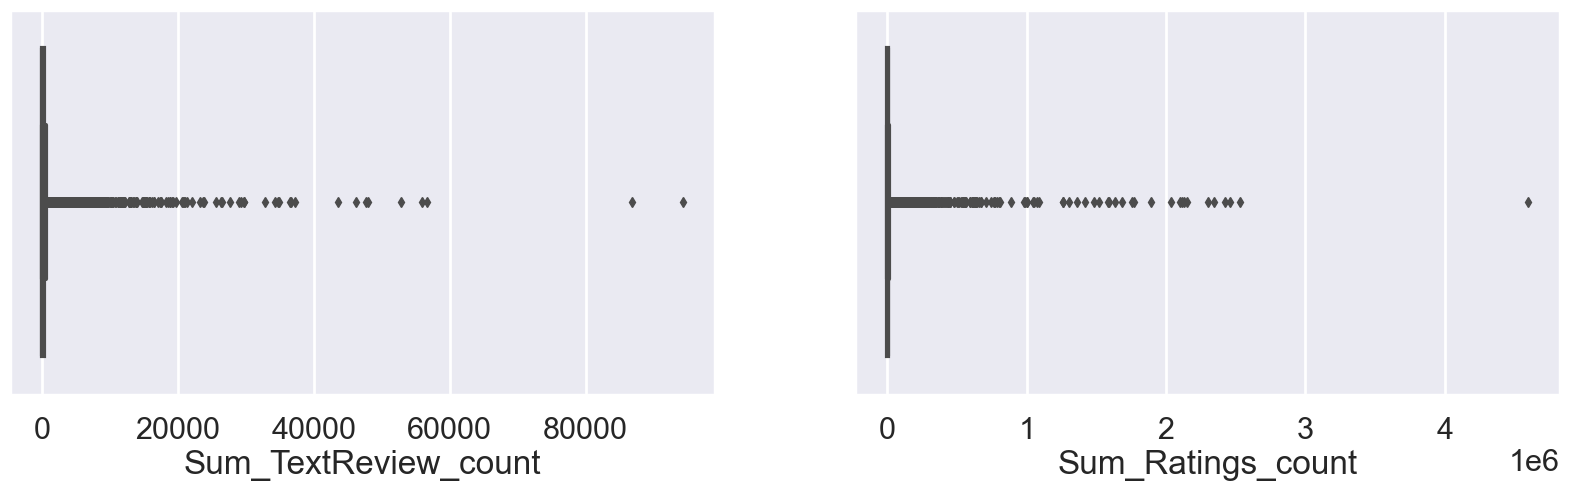

Sum_TextReview_count  Sum_TextReview_count
count          10352.000000          10352.000000
mean             582.420305            582.420305
std             2688.075959           2688.075959
min                0.000000              0.000000
25%                9.000000              9.000000
50%               51.000000             51.000000
75%              264.000000            264.000000
max            94265.000000          94265.000000

In [52]:
#Look closer into counts variables

# Create a figure with subplots
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

# Select the variables to plot
vars_to_plot = ['Sum_TextReview_count','Sum_Ratings_count']

# Loop through each variable and create a boxplot
for i, var in enumerate(vars_to_plot):
    sns.boxplot(data=df_unique, x=var, ax=axs[i])

# Display the plot
plt.show()


count_df = df_unique[['Sum_TextReview_count','Sum_TextReview_count']]
count_df.describe()

#We clearly see outliers, also lot of books haven't been rated lot of times. we should get rid of them.


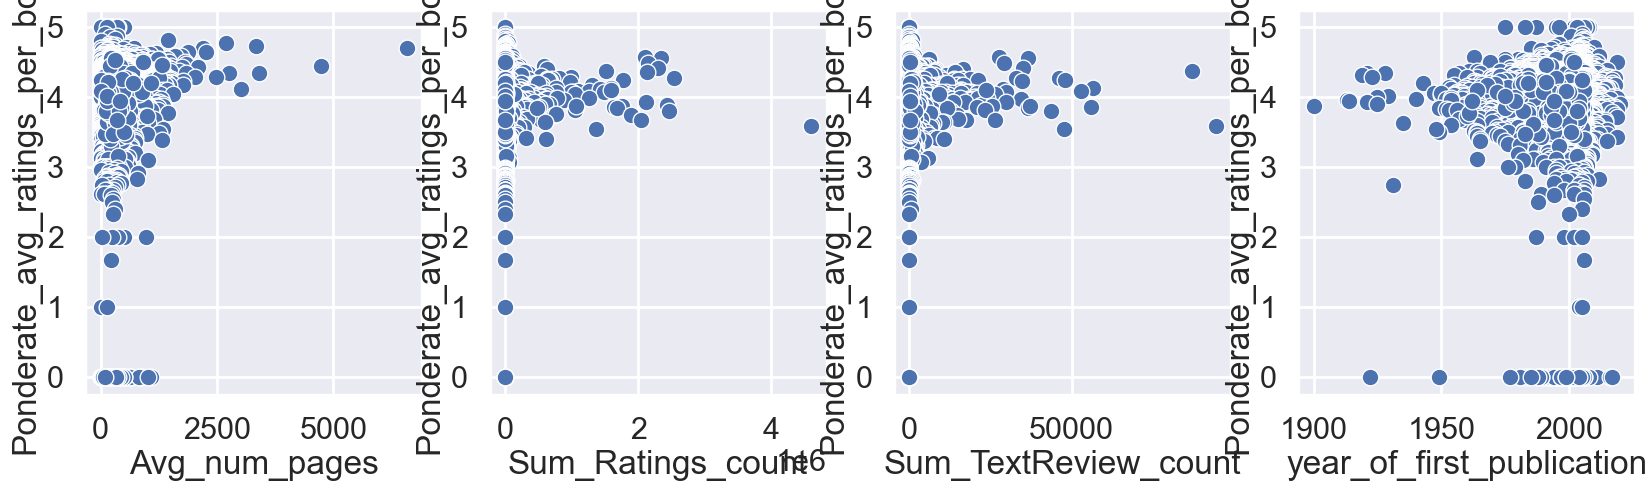

In [141]:
#Let's look at the relation between the target and the explanatory variables 

# Create a figure with subplots
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

# Select the target variable
target_var = 'Ponderate_avg_ratings_per_book'

# Select the explanatory variables
explanatory_vars = ['Avg_num_pages', 'Sum_Ratings_count', 'Sum_TextReview_count', 'year_of_first_publication']

# Loop through each explanatory variable and create a scatter plot
for i, var in enumerate(explanatory_vars):
    sns.scatterplot(data=df_unique, x=var, y=target_var, ax=axs[i])

# Display the plot
plt.show()

#We have a problem, we have a lot of problematic value around 0.
#ie: ratings count, it seems like lot of books have a low number of ratings and past an amount of ratings the  
#avg rating becomes a lot more concentrated.
# It is tricky because on one side, can we trust the avg rating for a low number of rating, and on the other side, there is a
#high chance that the book will be well rated if it is a famous one. 

       average_rating    num_pages  ratings_count  text_reviews_count  Occur  \
count       77.000000    77.000000           77.0           77.000000   77.0   
mean         2.575065   279.142857            0.0            0.025974    1.0   
std          1.906598   250.013353            0.0            0.160101    0.0   
min          0.000000     1.000000            0.0            0.000000    1.0   
25%          0.000000    64.000000            0.0            0.000000    1.0   
50%          3.580000   241.000000            0.0            0.000000    1.0   
75%          4.060000   357.000000            0.0            0.000000    1.0   
max          5.000000  1088.000000            0.0            1.000000    1.0   

       Avg_num_pages         year  year_of_first_publication  \
count      77.000000    77.000000                  77.000000   
mean      279.142857  1997.844156                1997.844156   
std       250.013353    12.843250                  12.843250   
min         1.000000  1

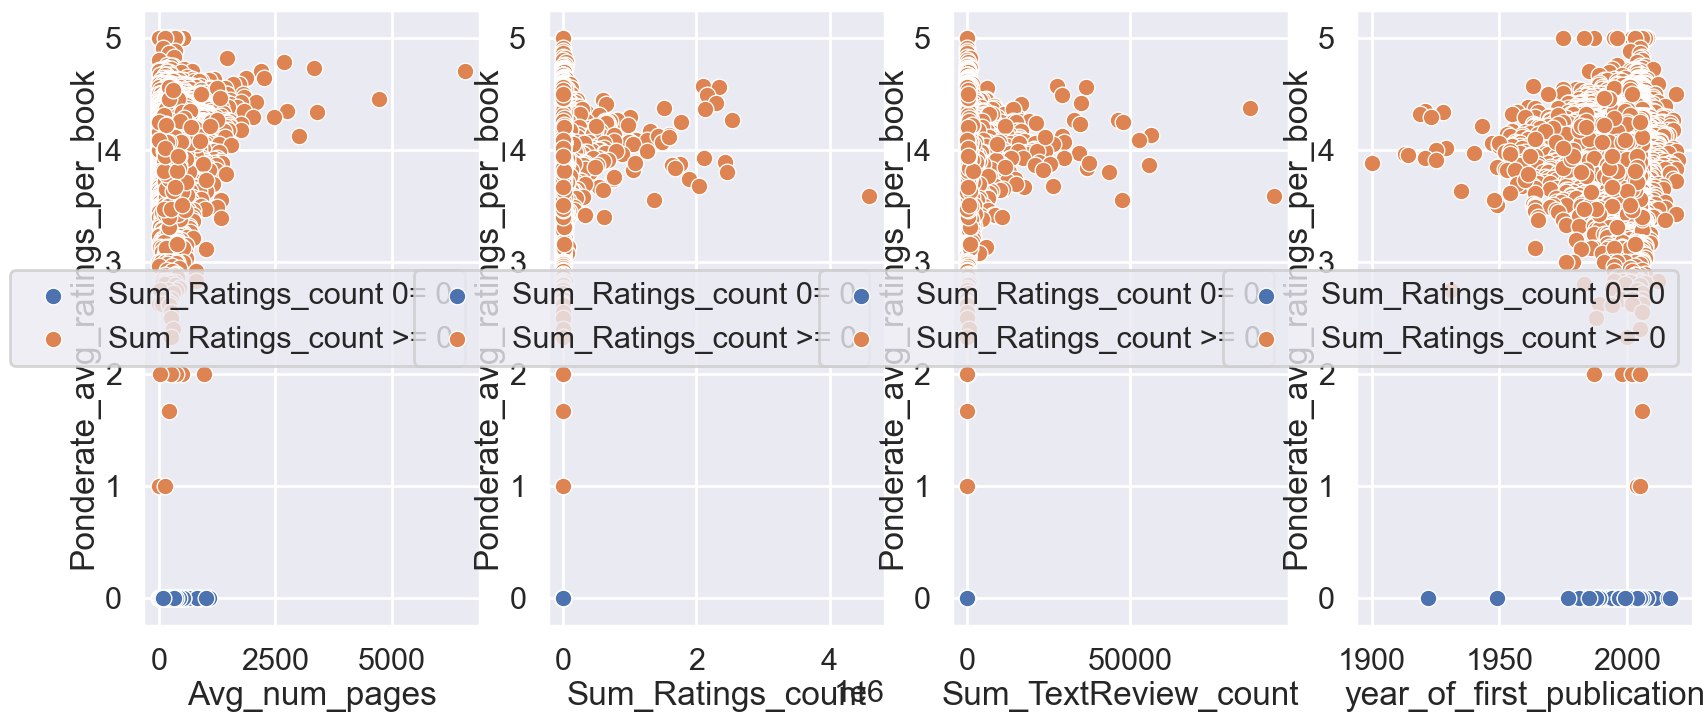

In [48]:
threshold = 0
# Select rows where 'ratings_count' is less than or equal to 100
lowrc_df = df_unique.loc[df['Sum_Ratings_count'] == threshold]

# Select rows where 'ratings_count' is greater than 100
high_df = df_unique.loc[df['Sum_Ratings_count'] > threshold]

# Get the summary statistics for each dataframe
lowrc_summary = lowrc_df.describe()
high_summary = high_df.describe()

# Concatenate the summary statistics horizontally
summary_concat = pd.concat([lowrc_summary, high_summary], axis=1)

# Display the concatenated summary statistics
print(summary_concat)


# Select the target variable
target_var = 'Ponderate_avg_ratings_per_book'

# Select the explanatory variables
explanatory_vars = ['Avg_num_pages', 'Sum_Ratings_count', 'Sum_TextReview_count', 'year_of_first_publication']

# Create a figure with subplots
fig, axs = plt.subplots(ncols=len(explanatory_vars), figsize=(20, 8))

# Loop through each explanatory variable and create a scatter plot
for i, var in enumerate(explanatory_vars):
    sns.scatterplot(data=lowrc_df, x=var, y=target_var, ax=axs[i], label=f'Sum_Ratings_count 0= {threshold}')
    sns.scatterplot(data=high_df, x=var, y=target_var, ax=axs[i], label=f'Sum_Ratings_count >= {threshold}')
    #sns.scatterplot(data=df, x=var, y=target_var, ax=axs[i], label=f'ratings_count >= 0')
    axs[i].legend()

# Display the plot
plt.show()


#All the books with a rating = 0 have 0 rating count. We can't keep them because those data are unreliable.

In [17]:
df_O = df_unique.loc[df_unique['Ponderate_avg_ratings_per_book'] == 0]
df_O.head(50)

#Let's drop those 0 value 
df_unique.drop(df_unique[df_unique['Sum_Ratings_count'] == 0].index, inplace=True)
df_unique.describe()



#I need to modify the code below and df_uniaue instead

C:\Users\Ben\AppData\Local\Temp\ipykernel_3904\1738504189.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.drop(df_unique[df_unique['Sum_Ratings_count'] == 0].index, inplace=True)


average_rating     num_pages  ratings_count  text_reviews_count  \
count    10275.000000  10275.000000   1.027500e+04        10275.000000   
mean         3.942912    334.829392   1.933708e+04          580.502384   
std          0.298504    238.258030   1.169073e+05         2676.356975   
min          1.000000      0.000000   1.000000e+00            0.000000   
25%          3.770000    195.000000   1.160000e+02           10.000000   
50%          3.960000    297.000000   8.830000e+02           52.000000   
75%          4.140000    411.500000   5.829500e+03          265.000000   
max          5.000000   6576.000000   4.597666e+06        94265.000000   

              Occur   Republished  Avg_num_pages          year  \
count  10275.000000  10275.000000   10275.000000  10275.000000   
mean       1.075426      0.047397     333.655572   2000.225596   
std        0.424405      0.212496     237.301946      8.122343   
min        1.000000      0.000000       0.000000   1900.000000   
25%        1.000000      0.000000     194.000000   1998.000000   
50%        1.000000      0.000000     296.000000   2003.000000   
75%        1.000000      0.000000     410.000000   2005.000000   
max        9.000000      1.000000    6576.000000   2020.000000   

       year_of_first_publication  Sum_Ratings_count  Sum_TextReview_count  \
count               10275.000000       1.027500e+04          10275.000000   
mean                 1999.978394       1.942369e+04            586.784720   
std                     8.370562       1.174306e+05           2697.655596   
min                  1900.000000       1.000000e+00              0.000000   
25%                  1998.000000       1.160000e+02             10.000000   
50%                  2002.000000       8.910000e+02             52.000000   
75%                  2005.000000       5.874500e+03            267.500000   
max                  2020.000000       4.597666e+06          94265.000000   

       Ponderate_avg_ratings_per_row  Ponderate_avg_ratings_per_book  
count                   10275.000000                    10275.000000  
mean                        3.926274                        3.942844  
std                         0.330073                        0.298461  
min                         1.000000                        1.000000  
25%                         3.760000                        3.770000  
50%                         3.950000                        3.960000  
75%                         4.130000                        4.140000  
max                         5.000000                        5.000000

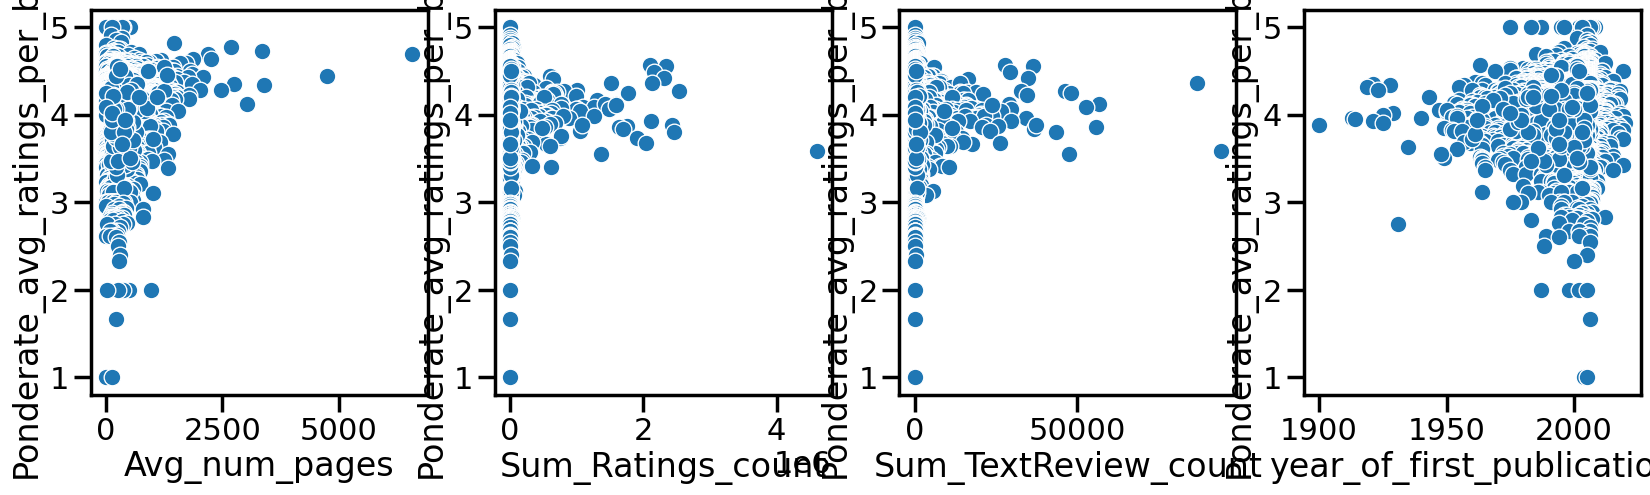

C:\Users\Ben\AppData\Local\Temp\ipykernel_3904\3031232797.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.drop(df_unique[df_unique['Avg_num_pages'] > 3000].index, inplace=True)
C:\Users\Ben\AppData\Local\Temp\ipykernel_3904\3031232797.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.drop(df_unique[df_unique['Sum_Ratings_count'] > 3000000].index, inplace=True)
C:\Users\Ben\AppData\Local\Temp\ipykernel_3904\3031232797.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

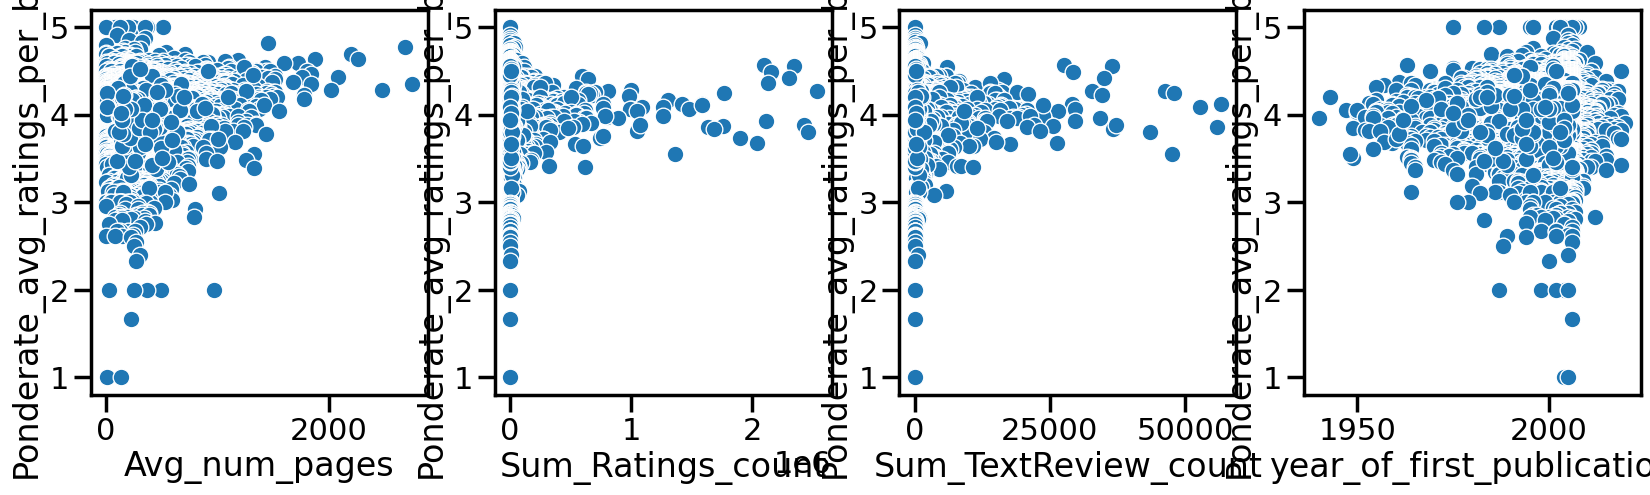

average_rating     num_pages  ratings_count  text_reviews_count  \
count    10255.000000  10255.000000   1.025500e+04        10255.000000   
mean         3.942642    332.828571   1.877423e+04          563.755729   
std          0.298130    220.568300   1.069128e+05         2365.120424   
min          1.000000      0.000000   1.000000e+00            0.000000   
25%          3.770000    195.000000   1.170000e+02           10.000000   
50%          3.960000    296.000000   8.850000e+02           52.000000   
75%          4.140000    410.000000   5.832500e+03          265.000000   
max          5.000000   2751.000000   2.530894e+06        56604.000000   

              Occur   Republished  Avg_num_pages          year  \
count  10255.000000  10255.000000   10255.000000  10255.000000   
mean       1.075085      0.047392     331.661531   2000.321307   
std        0.422013      0.212485     219.515744      7.658578   
min        1.000000      0.000000       0.000000   1940.000000   
25%        1.000000      0.000000     194.000000   1998.000000   
50%        1.000000      0.000000     295.000000   2003.000000   
75%        1.000000      0.000000     410.000000   2005.000000   
max        9.000000      1.000000    2751.000000   2020.000000   

       year_of_first_publication  Sum_Ratings_count  Sum_TextReview_count  \
count               10255.000000       1.025500e+04           10255.00000   
mean                 2000.080449       1.886064e+04             570.01609   
std                     7.890232       1.074863e+05            2389.27663   
min                  1940.000000       1.000000e+00               0.00000   
25%                  1998.000000       1.170000e+02              10.00000   
50%                  2003.000000       8.920000e+02              52.00000   
75%                  2005.000000       5.875000e+03             268.00000   
max                  2020.000000       2.530894e+06           56604.00000   

       Ponderate_avg_ratings_per_row  Ponderate_avg_ratings_per_book  
count                   10255.000000                    10255.000000  
mean                        3.926077                        3.942573  
std                         0.329602                        0.298087  
min                         1.000000                        1.000000  
25%                         3.760000                        3.770000  
50%                         3.950000                        3.960000  
75%                         4.130000                        4.140000  
max                         5.000000                        5.000000

In [18]:
#Let's deal with the outliers 

#Before 
#Let's look at the relation between the target and the explanatory variables 

# Create a figure with subplots
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

# Select the target variable
target_var = 'Ponderate_avg_ratings_per_book'

# Select the explanatory variables
explanatory_vars = ['Avg_num_pages', 'Sum_Ratings_count', 'Sum_TextReview_count', 'year_of_first_publication']

# Loop through each explanatory variable and create a scatter plot
for i, var in enumerate(explanatory_vars):
    sns.scatterplot(data=df_unique, x=var, y=target_var, ax=axs[i])

# Display the plot
plt.show()

#After

df_unique.drop(df_unique[df_unique['Avg_num_pages'] > 3000].index, inplace=True)
df_unique.drop(df_unique[df_unique['Sum_Ratings_count'] > 3000000].index, inplace=True)
df_unique.drop(df_unique[df_unique['Sum_TextReview_count'] > 80000].index, inplace=True)
df_unique.drop(df_unique[df_unique['year_of_first_publication'] < 1940].index, inplace=True)


#Let's look at the relation between the target and the explanatory variables 

# Create a figure with subplots
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

# Select the target variable
target_var = 'Ponderate_avg_ratings_per_book'

# Select the explanatory variables
explanatory_vars = ['Avg_num_pages', 'Sum_Ratings_count', 'Sum_TextReview_count', 'year_of_first_publication']

# Loop through each explanatory variable and create a scatter plot
for i, var in enumerate(explanatory_vars):
    sns.scatterplot(data=df_unique, x=var, y=target_var, ax=axs[i])

# Display the plot
plt.show()

df_unique.describe()

In [19]:
BadBooks = df_unique.loc[(df_unique['Ponderate_avg_ratings_per_book'] <=3.0)]
BadBooks.describe()
#We have 73 raws in this bins. This bins is already very large in term of rating but we can't do better 
#with the states of the data set
#We will have to smote this categorie


average_rating   num_pages  ratings_count  text_reviews_count  Occur  \
count       73.000000   73.000000      73.000000           73.000000   73.0   
mean         2.718630  237.493151     896.000000           67.479452    1.0   
std          0.412399  180.539940    3249.248879          183.373110    0.0   
min          1.000000    0.000000       1.000000            0.000000    1.0   
25%          2.670000  128.000000       3.000000            0.000000    1.0   
50%          2.830000  212.000000       6.000000            1.000000    1.0   
75%          3.000000  320.000000      65.000000            9.000000    1.0   
max          3.000000  972.000000   23409.000000          904.000000    1.0   

       Republished  Avg_num_pages         year  year_of_first_publication  \
count         73.0      73.000000    73.000000                  73.000000   
mean           0.0     237.493151  2000.643836                2000.643836   
std            0.0     180.539940     6.613055                   6.613055   
min            0.0       0.000000  1976.000000                1976.000000   
25%            0.0     128.000000  1998.000000                1998.000000   
50%            0.0     212.000000  2003.000000                2003.000000   
75%            0.0     320.000000  2005.000000                2005.000000   
max            0.0     972.000000  2012.000000                2012.000000   

       Sum_Ratings_count  Sum_TextReview_count  Ponderate_avg_ratings_per_row  \
count          73.000000             73.000000                      73.000000   
mean          896.000000             67.479452                       2.718630   
std          3249.248879            183.373110                       0.412399   
min             1.000000              0.000000                       1.000000   
25%             3.000000              0.000000                       2.670000   
50%             6.000000              1.000000                       2.830000   
75%            65.000000              9.000000                       3.000000   
max         23409.000000            904.000000                       3.000000   

       Ponderate_avg_ratings_per_book  
count                       73.000000  
mean                         2.718630  
std                          0.412399  
min                          1.000000  
25%                          2.670000  
50%                          2.830000  
75%                          3.000000  
max                          3.000000

In [81]:
#now medium to good 
med_goodBooks = df_unique.loc[(df_unique['Ponderate_avg_ratings_per_book'] >3) & (df_unique['Ponderate_avg_ratings_per_book'] <=4)]
med_goodBooks.describe()
#We have 5799 raws in this bins. This bins is very large in term of rows, we should trim it and keep only the best raws

#We see outliers already : 
#Years of pub 
#Years of pub, drop rows with years < 1950

#med_goodBooks = med_goodBooks.drop(med_goodBooks[med_goodBooks['year_of_first_publication'] < 1950].index)
#med_goodBooks.describe()

average_rating    num_pages  ratings_count  text_reviews_count  \
count     5799.000000  5799.000000   5.799000e+03         5799.000000   
mean         3.763632   306.376099   1.558000e+04          501.999310   
std          0.190535   167.105321   9.437180e+04         2081.433159   
min          3.020000     0.000000   1.000000e+00            0.000000   
25%          3.660000   197.000000   1.040000e+02            9.000000   
50%          3.810000   288.000000   7.970000e+02           52.000000   
75%          3.910000   384.000000   4.921000e+03          264.000000   
max          4.090000  1440.000000   2.457092e+06        55843.000000   

             Occur  Republished  Avg_num_pages         year  \
count  5799.000000  5799.000000    5799.000000  5799.000000   
mean      1.076565     0.049836     305.494913  2000.653389   
std       0.416130     0.217625     166.334731     7.329896   
min       1.000000     0.000000       0.000000  1940.000000   
25%       1.000000     0.000000     196.000000  1999.000000   
50%       1.000000     0.000000     288.000000  2003.000000   
75%       1.000000     0.000000     384.000000  2005.000000   
max       9.000000     1.000000    1440.000000  2020.000000   

       year_of_first_publication  Sum_Ratings_count  Sum_TextReview_count  \
count                5799.000000       5.799000e+03           5799.000000   
mean                 2000.410071       1.563385e+04            507.577858   
std                     7.605245       9.459258e+04           2103.789438   
min                  1940.000000       1.000000e+00              0.000000   
25%                  1998.000000       1.040000e+02              9.000000   
50%                  2003.000000       8.030000e+02             52.000000   
75%                  2005.000000       4.932000e+03            266.000000   
max                  2020.000000       2.457092e+06          55919.000000   

       Ponderate_avg_ratings_per_row  Ponderate_avg_ratings_per_book  
count                    5799.000000                     5799.000000  
mean                        3.748837                        3.763585  
std                         0.226172                        0.190464  
min                         1.361382                        3.020000  
25%                         3.650000                        3.660000  
50%                         3.800000                        3.810000  
75%                         3.910000                        3.910000  
max                         4.000000                        4.000000

In [83]:
#now very good books
vgoodBooks = df_unique.loc[(df['Ponderate_avg_ratings_per_book'] >4)]
vgoodBooks.describe()
#We have 4383 raws in this bins. This bins is also very large in term of rows, we should trim it and keep only the best raws ? 
#The question is can we trim the big bins without dammaging the small bin it term of size.


average_rating    num_pages  ratings_count  text_reviews_count  \
count     4383.000000  4383.000000   4.383000e+03         4383.000000   
mean         4.199870   369.414784   2.329819e+04          653.729181   
std          0.153653   271.926028   1.221634e+05         2709.152693   
min          3.980000     0.000000   1.000000e+00            0.000000   
25%          4.080000   193.000000   1.570000e+02           11.000000   
50%          4.170000   313.000000   1.063000e+03           53.000000   
75%          4.280000   464.000000   7.395500e+03          274.500000   
max          5.000000  2751.000000   2.530894e+06        56604.000000   

             Occur  Republished  Avg_num_pages         year  \
count  4383.000000  4383.000000    4383.000000  4383.000000   
mean      1.074378     0.044946     367.850103  1999.876569   
std       0.433046     0.207210     270.651700     8.068373   
min       1.000000     0.000000       0.000000  1943.000000   
25%       1.000000     0.000000     192.000000  1997.000000   
50%       1.000000     0.000000     310.000000  2002.000000   
75%       1.000000     0.000000     464.000000  2005.000000   
max       9.000000     1.000000    2751.000000  2019.000000   

       year_of_first_publication  Sum_Ratings_count  Sum_TextReview_count  \
count                4383.000000       4.383000e+03           4383.000000   
mean                 1999.634953       2.342911e+04            660.995893   
std                     8.251301       1.231086e+05           2735.700447   
min                  1943.000000       1.000000e+00              0.000000   
25%                  1997.000000       1.580000e+02             11.000000   
50%                  2002.000000       1.073000e+03             53.000000   
75%                  2005.000000       7.541000e+03            278.500000   
max                  2019.000000       2.530894e+06          56604.000000   

       Ponderate_avg_ratings_per_row  Ponderate_avg_ratings_per_book  
count                    4383.000000                     4383.000000  
mean                        4.180687                        4.199772  
std                         0.230294                        0.153667  
min                         1.433488                        4.010000  
25%                         4.080000                        4.080000  
50%                         4.167830                        4.170000  
75%                         4.280000                        4.280000  
max                         5.000000                        5.000000

C:\Users\Ben\AppData\Local\Temp\ipykernel_3904\3183193985.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['rating_class'] = pd.cut(df_unique['Ponderate_avg_ratings_per_book'], bins=cutoffs, labels=['bad books', 'average books', 'very good books'])


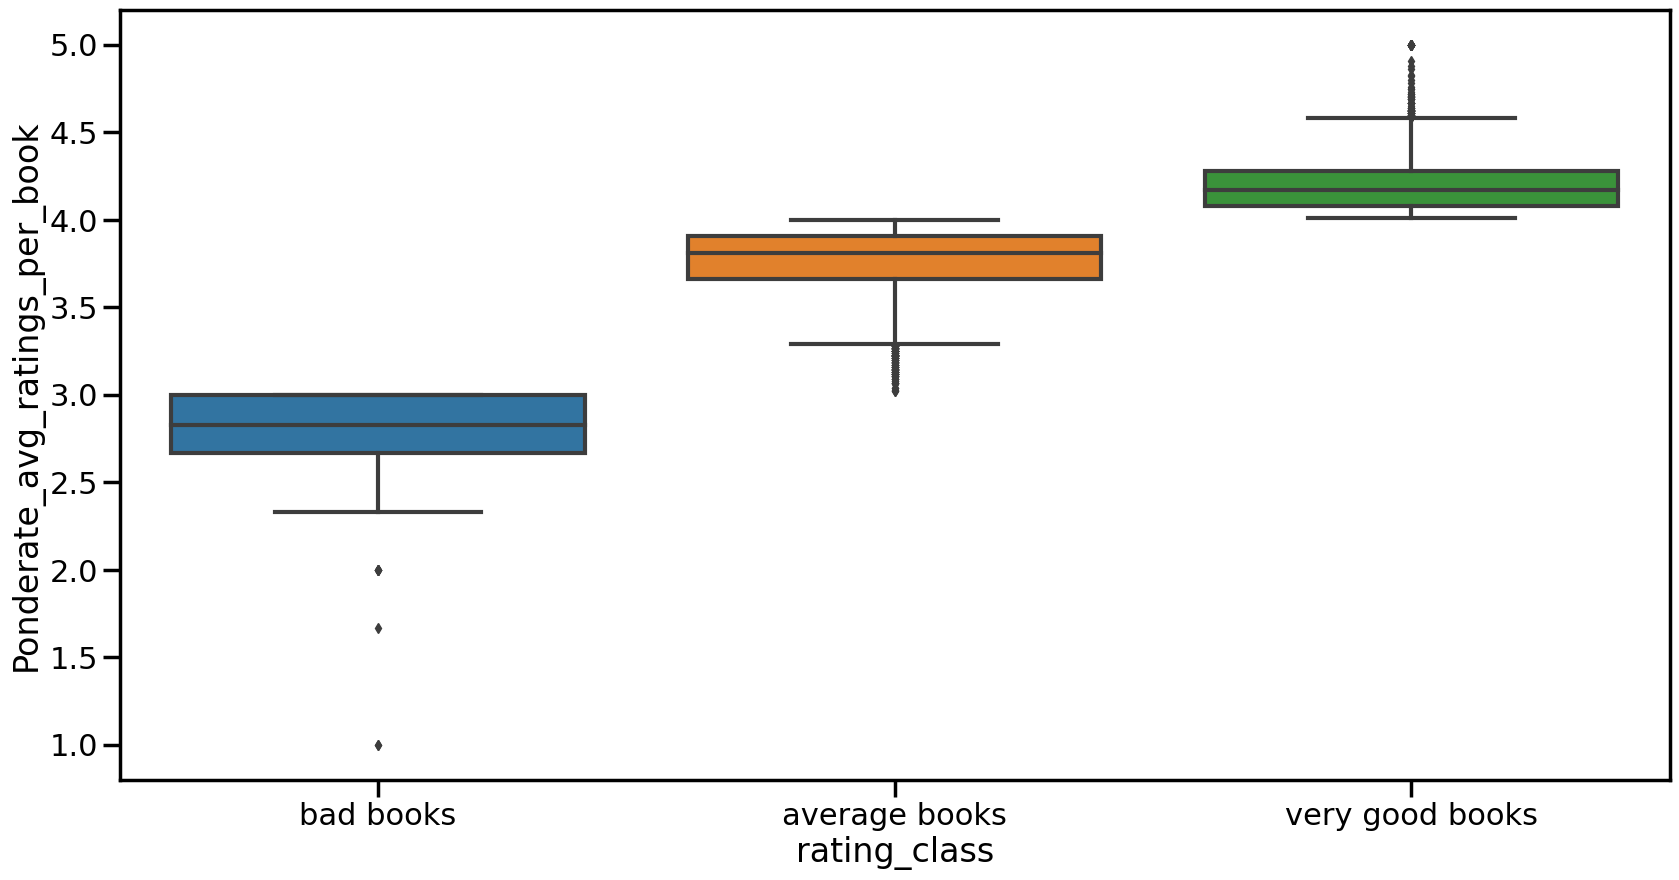

average books      5799
very good books    4383
bad books            73
Name: rating_class, dtype: int64

In [20]:
#Let's build a new rating model : rating class

# define the cutoffs for the rating classes
cutoffs = [0.0, 3.0, 4.0, 5.0]

# create a new column with the rating classes
df_unique['rating_class'] = pd.cut(df_unique['Ponderate_avg_ratings_per_book'], bins=cutoffs, labels=['bad books', 'average books', 'very good books'])
df_unique.describe()

plt.figure(figsize=(20,10))
sns.boxplot(x=df_unique.rating_class,y=df_unique.Ponderate_avg_ratings_per_book)
plt.show()


df_unique.rating_class.value_counts() 

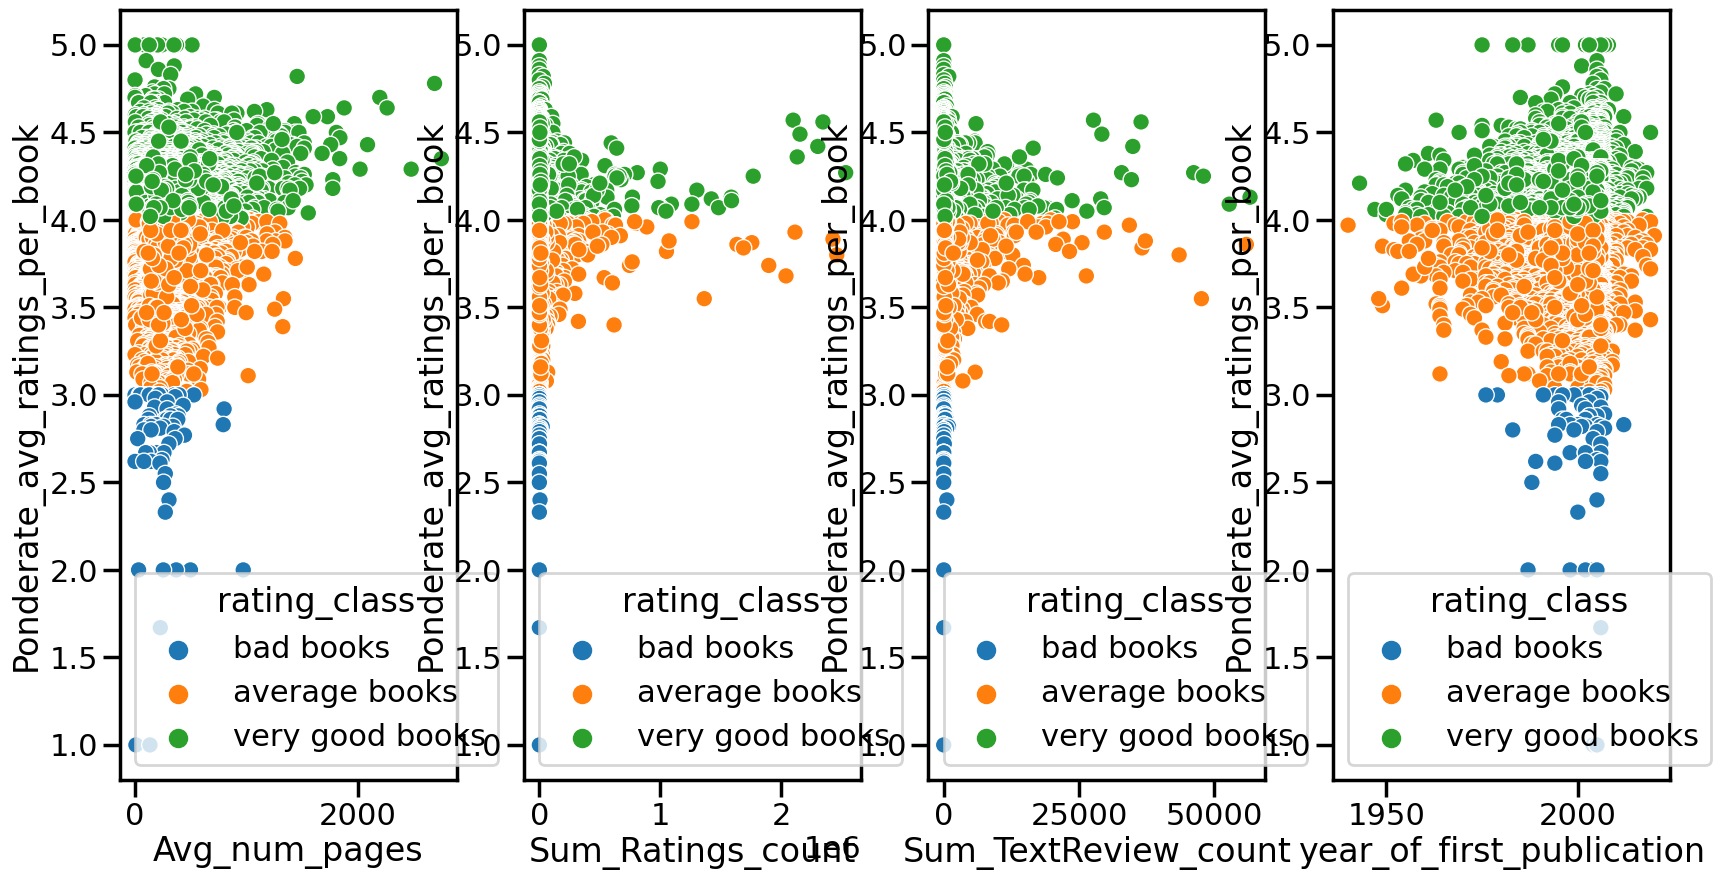

In [21]:
#Let's look at the relation between the target and the explanatory variables 

# Create a figure with subplots
fig, axs = plt.subplots(ncols=4, figsize=(20, 10))

# Select the target variable
target_var = 'Ponderate_avg_ratings_per_book'

# Select the explanatory variables
explanatory_vars = ['Avg_num_pages', 'Sum_Ratings_count', 'Sum_TextReview_count', 'year_of_first_publication']

# Loop through each explanatory variable and create a scatter plot
for i, var in enumerate(explanatory_vars):
    sns.scatterplot(data=df_unique, x=var, y=target_var, hue= "rating_class", ax=axs[i])

# Display the plot
plt.show()

#Seems like text review count, num pages and maybe year of publication can bring some information on the classification
#The results are not net though. It will be hard to discriminate between medium and good

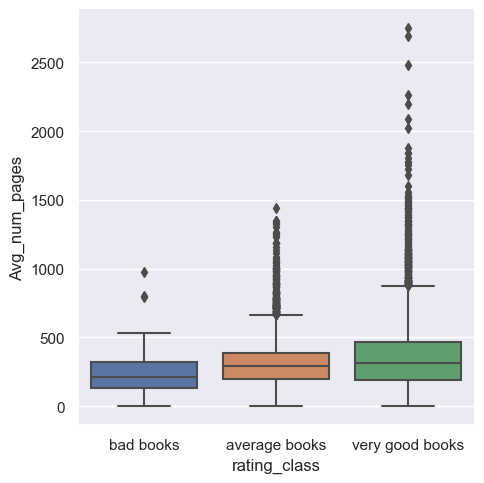

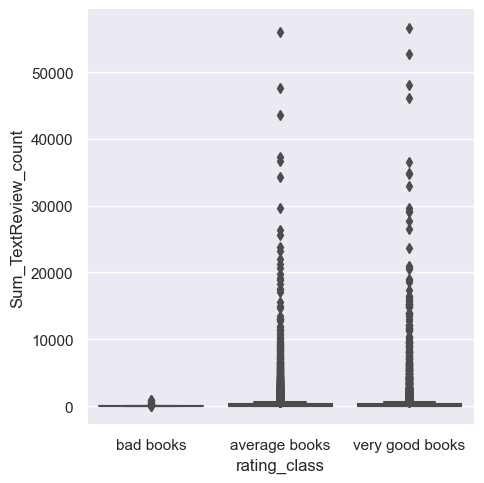

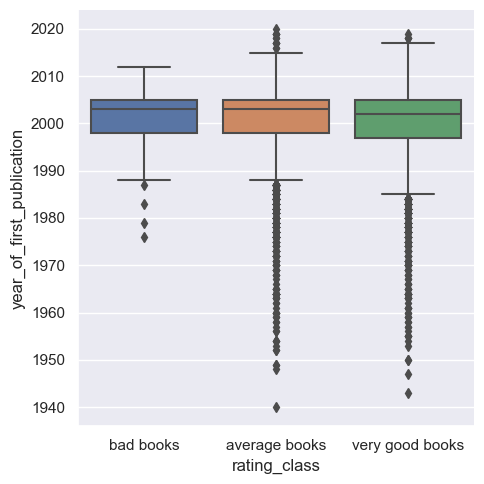

In [86]:
sns.set(rc={'figure.figsize':(20,10)})

# create a boxplot for each numerical variable and rating class
sns.catplot(data=df_unique, kind="box", x="rating_class", y="Avg_num_pages")
sns.catplot(data=df_unique, kind="box", x="rating_class", y="Sum_TextReview_count")
sns.catplot(data=df_unique, kind="box", x="rating_class", y="year_of_first_publication")

# show the plots
plt.show()

#It is going to be hard to discriminate the average books from the very good 

C:\Users\Ben\AppData\Local\Temp\ipykernel_3904\3143957792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['PublisherOccur'] = df_unique.groupby('publisher')['publisher'].transform('size')


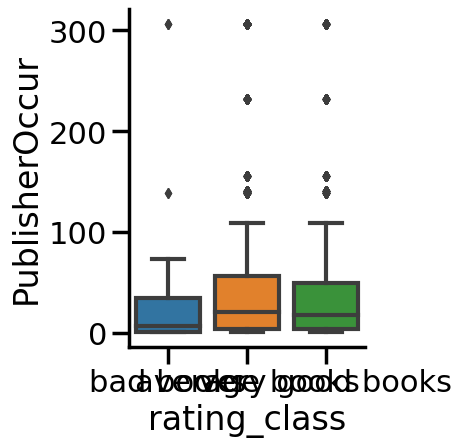

In [22]:
#Publisher Occur is the number of time we se this publisher in the dataset, We try to see if a big publisher publish better books ?
df_unique['PublisherOccur'] = df_unique.groupby('publisher')['publisher'].transform('size')
df_unique.describe()

sns.catplot(data=df_unique, kind="box", x="rating_class", y="PublisherOccur")
# show the plots
plt.show()

#It would be more interesting to look at if the publisher already has a very good book published ? 

In [17]:
df_unique.head(10) 

title  \
bookID                                                      
23552                         The New Big Book of America   
32823        Fanning the Flame: Bible  Cross  and Mission   
20957   Colossians and Philemon: A Critical and Exeget...   
17224   The Diamond Color Meditation: Color Pathway to...   
25426   Delwau Duon: Peintiadau Nicholas Evans = Symph...   
18184   The Complete Theory Fun Factory: Music Theory ...   
2843    Literature Circle Guide: Bridge to Terabithia:...   
38804       The Irish Anatomist: A Study of Flann O'Brien   
36853                  Tyrannosaurus Wrecks (Stanley  #1)   
4287    Middlesex Borough (Images of America: New Jersey)   

                                                  authors  average_rating  \
bookID                                                                      
23552                                Todd Davis/Marc Frey             5.0   
32823    Chris    Green/Chris Wright/Paul Douglas Gardner             5.0   
20957                                      R. McL. Wilson             5.0   
17224                                       John  Diamond             5.0   
25426                     Nicholas    Evans/Rhonda  Evans             5.0   
18184                     Ian        Martin/Katie Elliott             5.0   
2843                                       Tara MacCarthy             5.0   
38804                                       Keith Donohue             5.0   
36853   Laura Driscoll/Alisa Klayman-Grodsky/Eric     ...             5.0   
4287                 Middlesex Borough Heritage Committee             5.0   

       language_code  num_pages  ratings_count  text_reviews_count  \
bookID                                                               
23552            eng         56              2                   1   
32823            eng        336              1                   1   
20957            eng        512              1                   0   
17224            eng         74              5                   3   
25426            wel        150              1                   0   
18184            eng         96              1                   0   
2843             eng         32              4                   1   
38804            eng        222              1                   0   
36853            eng         24              2                   1   
4287             eng        128              2                   0   

       publication_date              publisher  Occur  Republished  \
bookID                                                               
23552         3/21/2002          Courage Books      1            0   
32823         6/17/2003              Zondervan      1            0   
20957        12/07/2005        T&T Clark Int'l      1            0   
17224         2/01/2006  Square One Publishers      1            0   
25426         6/22/1987                Y Lolfa      1            0   
18184         6/01/2004    Boosey & Hawkes Inc      1            0   
2843          1/01/2002     Teaching Resources      1            0   
38804         7/25/2003        Academica Press      1            0   
36853         2/01/2003           Disney Press      1            0   
4287          3/17/2003     Arcadia Publishing      1            0   

        Avg_num_pages  year  year_of_first_publication  Sum_Ratings_count  \
bookID                                                                      
23552            56.0  2002                       2002                  2   
32823           336.0  2003                       2003                  1   
20957           512.0  2005                       2005                  1   
17224            74.0  2006                       2006                  5   
25426           150.0  1987                       1987                  1   
18184            96.0  2004                       2004                  1   
2843             32.0  2002                       2002                  4   
38804           222

In [18]:
df_unique.nunique() 

title                             10331
authors                            6276
average_rating                      209
language_code                        26
num_pages                           967
ratings_count                      5182
text_reviews_count                 1809
publication_date                   3504
publisher                          2198
Occur                                 9
Republished                           2
Avg_num_pages                       968
year                                 74
year_of_first_publication            75
Sum_Ratings_count                  5193
Sum_TextReview_count               1815
Ponderate_avg_ratings_per_row       691
Ponderate_avg_ratings_per_book      209
rating_class                          3
PublisherOccur                       70
dtype: int64

In [88]:
#There's no republished books into the bad category
df_unique.groupby(["rating_class","Republished"]).count()

#It will be hqrd to distinguish 

title  authors  average_rating  language_code  \
rating_class    Republished                                                  
bad books       0               73       73              73             73   
                1                0        0               0              0   
average books   0             5510     5510            5510           5510   
                1              289      289             289            289   
very good books 0             4186     4186            4186           4186   
                1              197      197             197            197   

                             num_pages  ratings_count  text_reviews_count  \
rating_class    Republished                                                 
bad books       0                   73             73                  73   
                1                    0              0                   0   
average books   0                 5510           5510                5510   
                1                  289            289                 289   
very good books 0                 4186           4186                4186   
                1                  197            197                 197   

                             publication_date  publisher  Occur  \
rating_class    Republished                                       
bad books       0                          73         73     73   
                1                           0          0      0   
average books   0                        5510       5510   5510   
                1                         289        289    289   
very good books 0                        4186       4186   4186   
                1                         197        197    197   

                             Avg_num_pages  year  year_of_first_publication  \
rating_class    Republished                                                   
bad books       0                       73    73                         73   
                1                        0     0                          0   
average books   0                     5510  5510                       5510   
                1                      289   289                        289   
very good books 0                     4186  4186                       4186   
                1                      197   197                        197   

                             Sum_Ratings_count  Sum_TextReview_count  \
rating_class    Republished                                            
bad books       0                           73                    73   
                1                            0                     0   
average books   0                         5510                  5510   
                1                          289                   289   
very good books 0                         4186                  4186   
                1                          197                   197   

                             Ponderate_avg_ratings_per_row  \
rating_class    Republished                                  
bad books       0                                       73   
                1                                        0   
average books   0                                     5510   
                1                                      289   
very good books 0                                     4186   
                1                                      197   

                             Ponderate_avg_ratings_per_book  PublisherOccur  
rating_class    Republished                                                  
bad books       0                                        73              73  
                1                                         0               0  
average books   0                                      5510            5510  
                1                                       289             289  
very good books 0                                      4186            4186

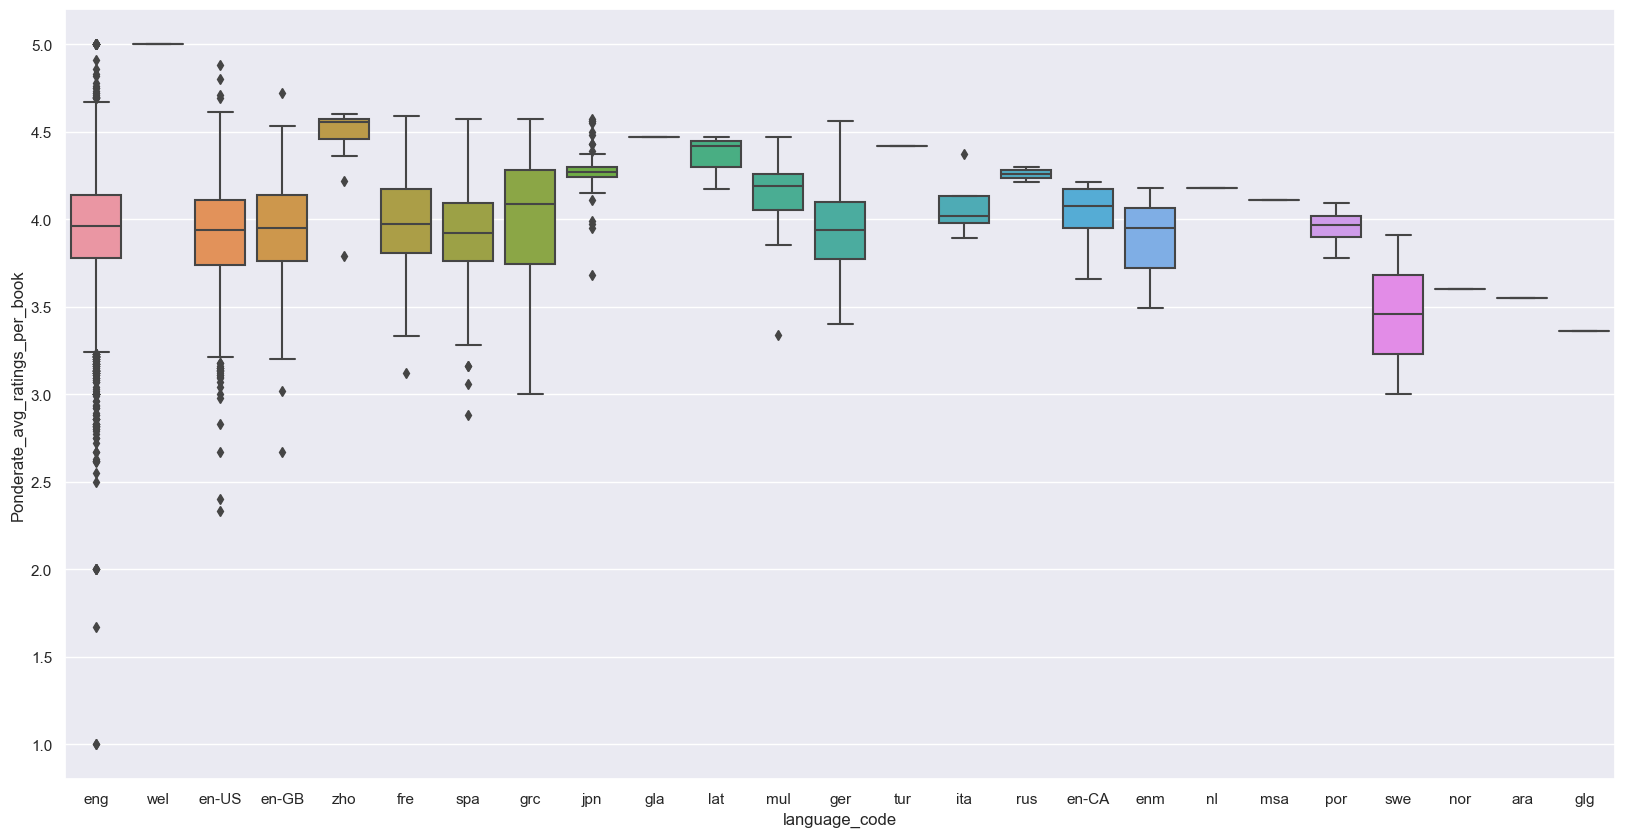

eng      8233
en-US    1299
spa       193
en-GB     187
fre       131
ger        91
jpn        45
mul        15
zho        14
por        10
grc         8
en-CA       6
ita         5
lat         3
enm         3
swe         2
rus         2
tur         1
nl          1
msa         1
wel         1
gla         1
nor         1
ara         1
glg         1
Name: language_code, dtype: int64


language_code
wel      5.000000
gla      4.470000
zho      4.456429
tur      4.420000
lat      4.353333
jpn      4.273333
rus      4.255000
nl       4.180000
mul      4.123333
msa      4.110000
ita      4.078000
en-CA    4.021667
grc      3.988750
fre      3.977786
por      3.945000
eng      3.944139
ger      3.941868
en-GB    3.927807
spa      3.915440
en-US    3.913626
enm      3.873333
nor      3.600000
ara      3.550000
swe      3.455000
glg      3.360000
Name: Ponderate_avg_ratings_per_book, dtype: float64

In [89]:
#After a big thinking we gonna keep only one book title, so we gonna compute the total ratings count; the average num of pages and the average year of publication per book, 
#and delete all the duplicates. But before, we need to check if the language code have an impact on the average rating because
#some books have a version in different languages (ie. Salem's lot)
plt.figure(figsize=(20,10))
sns.boxplot(x=df_unique.language_code,y=df_unique.Ponderate_avg_ratings_per_book)
plt.show()
#First we see that the languages does have an impact on the mean of the aveage ratings but also on its standard deviation

print(df_unique.language_code.value_counts())
# We look at the differents books languages. Most of them are in english. This data is highly unbalanced. 
#Some languages are underrepresented I will only keep the languages with at list 10 books in the first place 
#so we actually can't use this variable 

df_unique.groupby(["language_code"]).mean(numeric_only=True).Ponderate_avg_ratings_per_book.sort_values(ascending=False)

#Because of higly unbalanced data set, we gonna only keep english books, our model will be set for english books

# select all rows in the dataframe that start with 'app'
#eng_df = df[df['language_code'].str.startswith(('en-', 'eng'))]
#eng_df.groupby(["language_code"]).mean(numeric_only=True).average_rating.sort_values(ascending=False)



C:\Users\Ben\AppData\Local\Temp\ipykernel_3904\2599892101.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['language_group'] = df_unique['language_code'].apply(group_language_code)


eng    9725
spa     193
fre     131
ger      91
jpn      45
mul      15
zho      14
por      10
grc       8
ita       5
lat       3
enm       3
rus       2
swe       2
ara       1
nor       1
tur       1
msa       1
nl        1
wel       1
gla       1
glg       1
Name: language_group, dtype: int64
eng    9725
spa     193
fre     131
ger      91
Name: language_group, dtype: int64


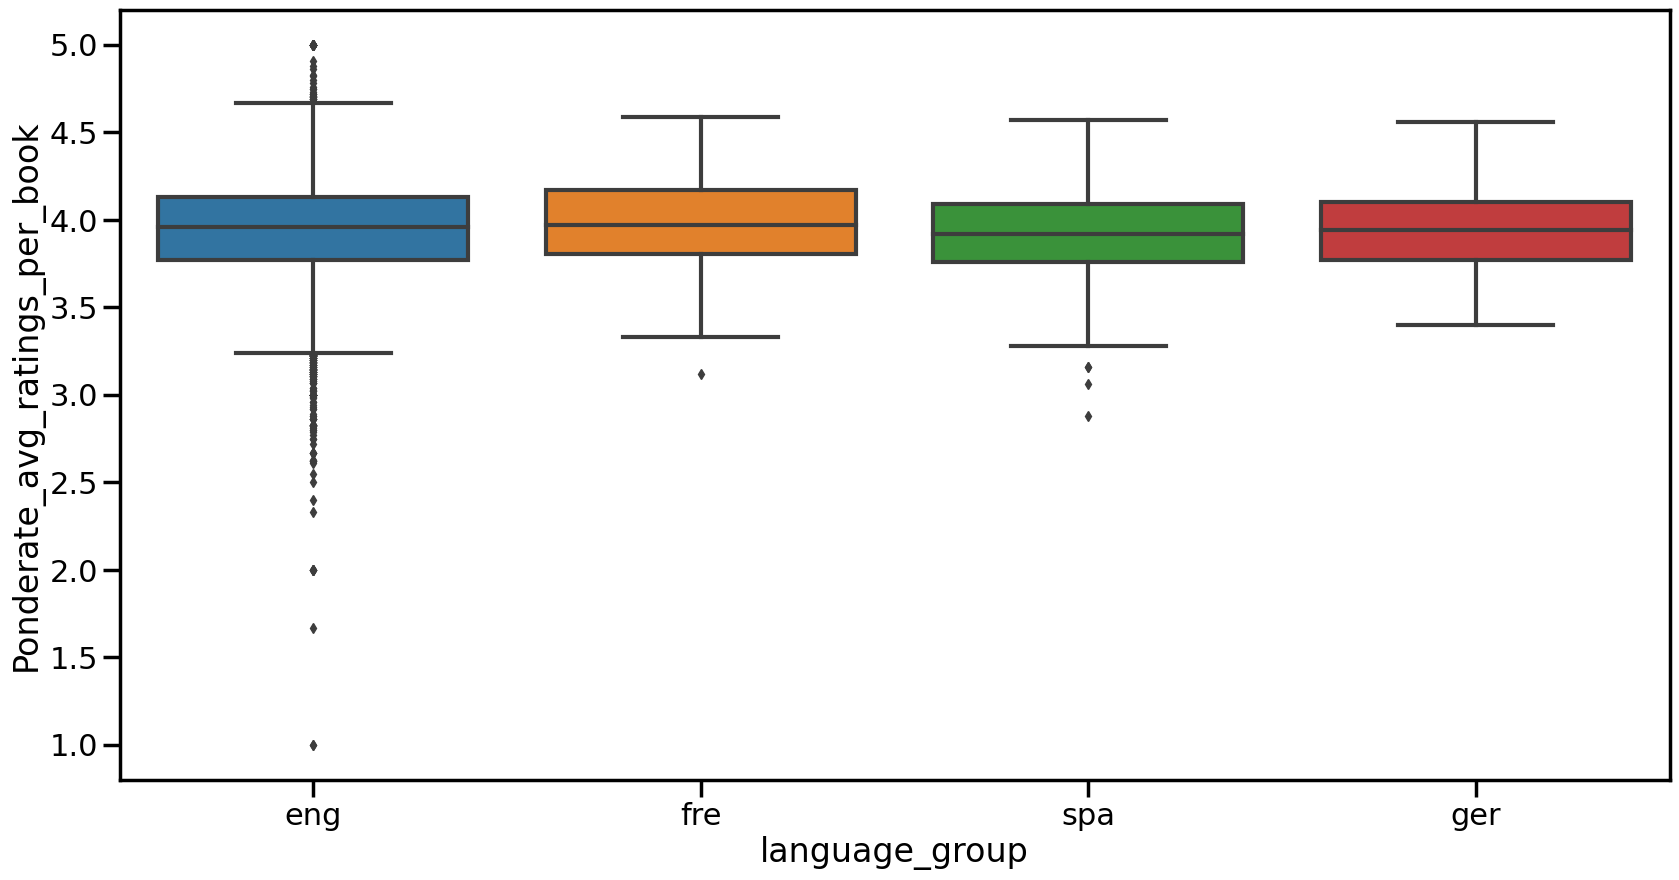

In [23]:
#let's regroup the english languages together 

# create a new column based on language codes
def group_language_code(code):
    if code in ['eng', 'en-CA', 'en-GB', 'en-US']:
        return 'eng'
    else:
        return code

df_unique['language_group'] = df_unique['language_code'].apply(group_language_code)
print(df_unique.language_group.value_counts())

#Then we only keep the first 4 languages 

# drop rows with less than 2 books in each language group
min_books_per_group = 90
df_filtered = df_unique.groupby('language_group').filter(lambda x: len(x) >= min_books_per_group)

print(df_filtered.language_group.value_counts())

(df_filtered.groupby(["rating_class","language_group"]).count())
#new count per rating class
df_filtered.rating_class.value_counts() 

#some books have a version in different languages (ie. Salem's lot)
plt.figure(figsize=(20,10))
sns.boxplot(x=df_filtered.language_group,y=df_unique.Ponderate_avg_ratings_per_book)
plt.show()

In [ ]:
#We don.t see any impact on the ratings so we will drop all books that are not english 

min_books_per_group = 90
df_filtered = df_unique.groupby('language_group').filter(lambda x: len(x) >= min_books_per_group)

print(df_filtered.language_group.value_counts())

(df_filtered.groupby(["rating_class","language_group"]).count())
#new count per rating class
df_filtered.rating_class.value_counts() 


<AxesSubplot: xlabel='Title_word_count', ylabel='Ponderate_avg_ratings_per_book'>

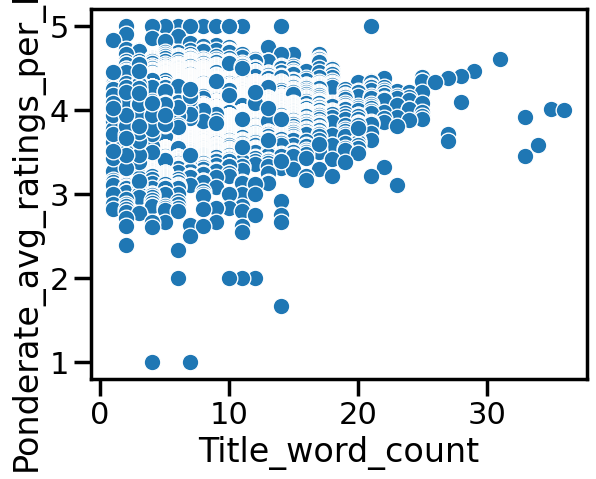

In [24]:
#finally with the title, we want to look if the number of words has an impact on the rating

# Define a function to count words in a string
def count_words(string):
    return len(string.split())

# Apply the function to the 'Bio' column and create a new column with the counts
df_filtered['Title_word_count'] = df_filtered['title'].apply(count_words)
df_filtered.describe()

sns.scatterplot(data=df_filtered,x="Title_word_count",y="Ponderate_avg_ratings_per_book")

#We see a small correlation

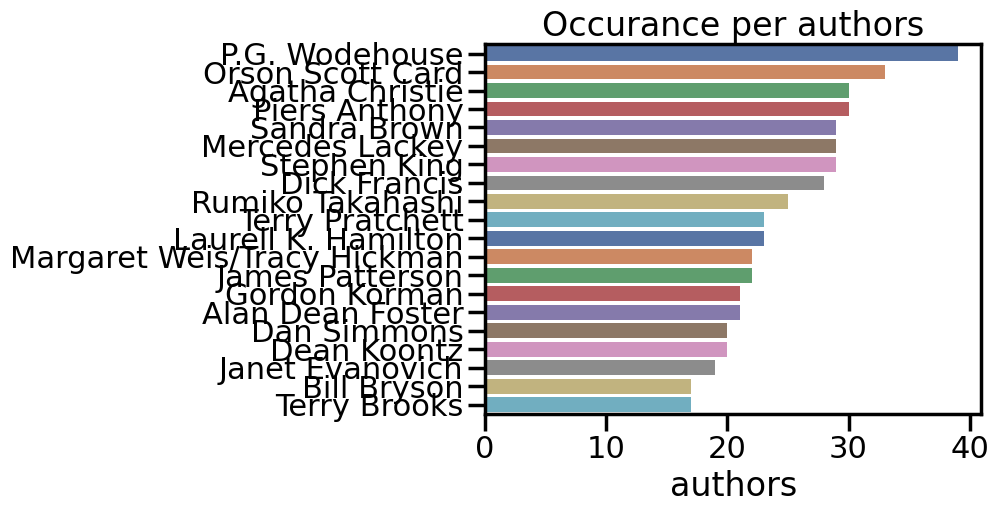

<AxesSubplot: xlabel='Occur_authors', ylabel='Ponderate_avg_ratings_per_book'>

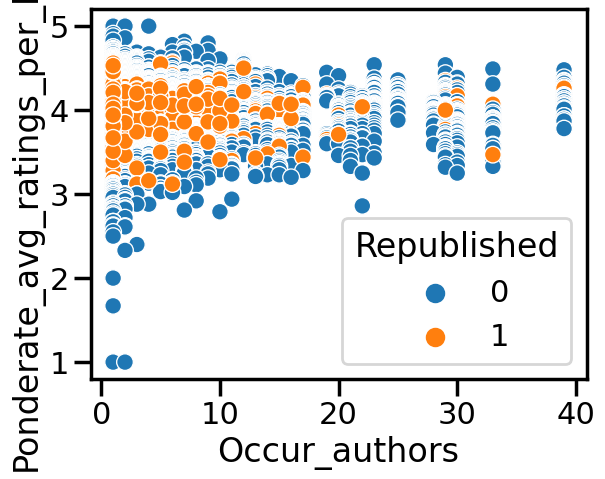

In [25]:
#2) find a way to look if the number of books written by an authors is correlated with the average rating of his books 

#Here are the most famus authors
authors = df_filtered['authors'].value_counts()[:20]
sns.barplot(x=authors, y=authors.index, palette= 'deep').set(title='Occurance per authors')
plt.show()


#New column with the occurance of an author
df_filtered['Occur_authors'] = df_filtered.groupby('authors')['authors'].transform('size')


sns.scatterplot(data=df_filtered,x="Occur_authors",y="Ponderate_avg_ratings_per_book",hue= "Republished")

#We see that the min rating gets higher for a higher number of occurances but the relation is not strong.

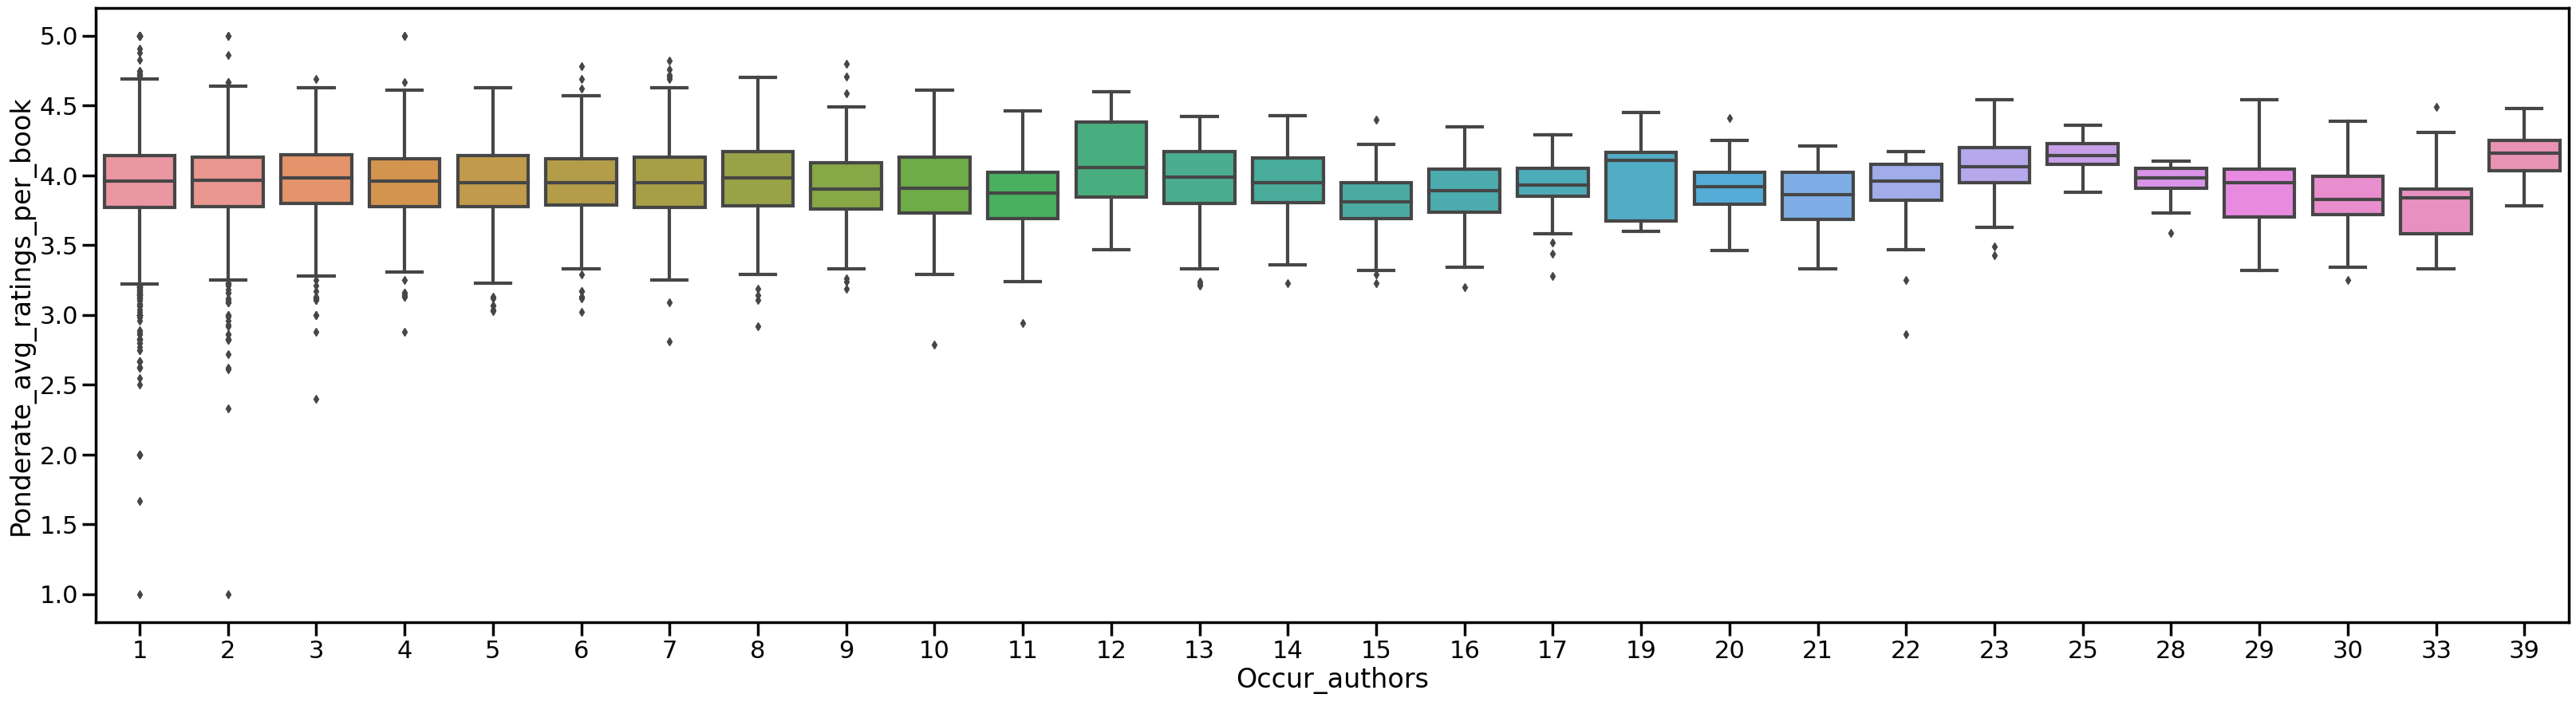

average_rating    num_pages  ratings_count  text_reviews_count  \
count     5217.000000  5217.000000   5.217000e+03         5217.000000   
mean         3.939440   347.254552   2.632117e+04          763.697144   
std          0.283976   216.311446   1.310668e+05         2745.972240   
min          1.000000     0.000000   1.000000e+00            0.000000   
25%          3.770000   208.000000   3.170000e+02           20.000000   
50%          3.950000   312.000000   2.070000e+03          102.000000   
75%          4.130000   421.000000   1.078100e+04          452.000000   
max          5.000000  2690.000000   2.530894e+06        56604.000000   

             Occur  Republished  Avg_num_pages         year  \
count  5217.000000  5217.000000    5217.000000  5217.000000   
mean      1.071880     0.051562     345.948821  2000.483036   
std       0.373603     0.221163     215.704868     7.277723   
min       1.000000     0.000000       0.000000  1940.000000   
25%       1.000000     0.000000     208.000000  1998.000000   
50%       1.000000     0.000000     310.000000  2003.000000   
75%       1.000000     0.000000     421.000000  2005.000000   
max       9.000000     1.000000    2690.000000  2020.000000   

       year_of_first_publication  Sum_Ratings_count  Sum_TextReview_count  \
count                5217.000000       5.217000e+03           5217.000000   
mean                 2000.262603       2.643977e+04            771.213533   
std                     7.439122       1.318781e+05           2776.442034   
min                  1940.000000       1.000000e+00              0.000000   
25%                  1998.000000       3.180000e+02             20.000000   
50%                  2003.000000       2.071000e+03            104.000000   
75%                  2005.000000       1.082400e+04            456.000000   
max                  2020.000000       2.530894e+06          56604.000000   

       Ponderate_avg_ratings_per_row  Ponderate_avg_ratings_per_book  \
count                    5217.000000                     5217.000000   
mean                        3.924730                        3.939402   
std                         0.312115                        0.283946   
min                         1.000000                        1.000000   
25%                         3.760000                        3.770000   
50%                         3.950000                        3.950000   
75%                         4.120000                        4.130000   
max                         5.000000                        5.000000   

       PublisherOccur  Title_word_count  Occur_authors  
count     5217.000000       5217.000000    5217.000000  
mean        50.907035          5.686218       7.699252  
std         71.624572          3.579920       7.206756  
min          1.000000          1.000000       2.000000  
25%          7.000000          3.000000       3.000000  
50%         23.000000          5.000000       5.000000  
75%         61.000000          7.000000       9.000000  
max        306.000000         35.000000      39.000000

In [53]:
#Lets look at the subdataset of authors who wrote more than one book

FamousWritter = df_filtered[df_filtered.duplicated(subset=['authors'],keep=False)]


FamousWritter.sort_values(by='Occur_authors', ascending=False) 
#df.describe()
plt.figure(figsize=(40,10))
sns.boxplot(x=df_filtered.Occur_authors,y=df_filtered.Ponderate_avg_ratings_per_book)
plt.show()
FamousWritter.describe()

#not very significative

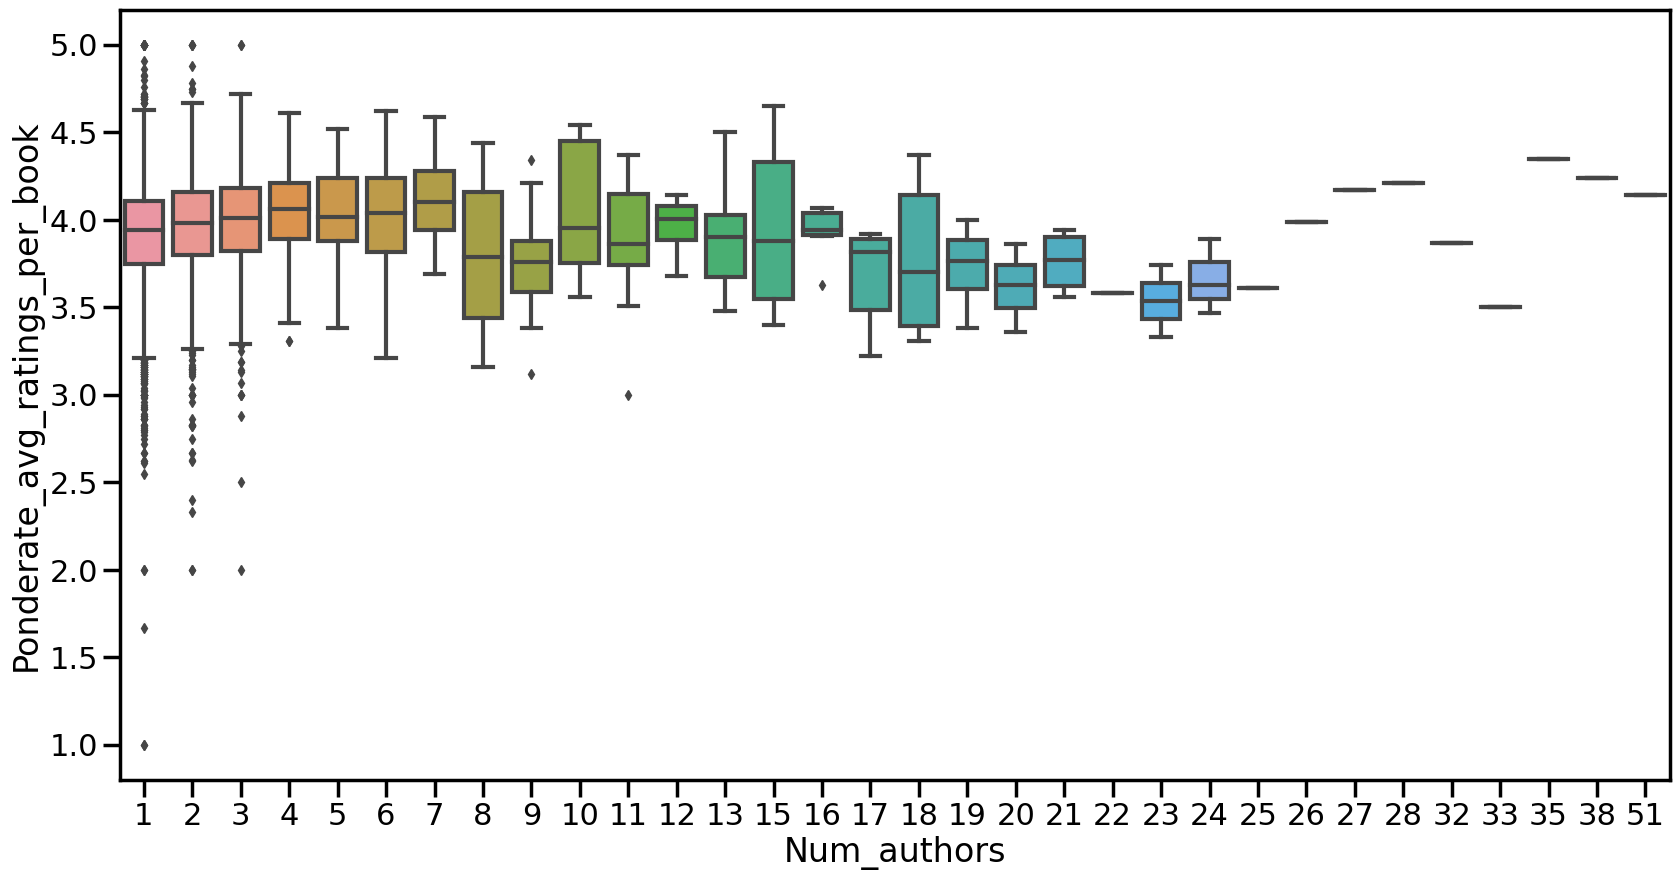

1     6147
2     2710
3      857
4      189
5       56
6       50
7       20
10      12
15      10
8       10
9        9
11       9
18       8
13       8
21       7
16       6
17       6
12       4
19       4
24       3
20       3
23       2
22       1
25       1
32       1
28       1
26       1
51       1
27       1
38       1
35       1
33       1
Name: Num_authors, dtype: int64

In [26]:
#3) Find a way to count the number of authors of the book --> Count the number of "/" +1 = number of authors

df_filtered['Num_authors'] = df_filtered['authors'].str.count('/') +1
df_filtered.describe()


plt.figure(figsize=(20,10))
sns.boxplot(x=df_filtered.Num_authors,y=df_filtered.Ponderate_avg_ratings_per_book)
plt.show()
#We see that up to 7 authors the mean of average rating seems to rise and then the relation seems to reverse. 
#The number of books in each categories must be very low for many categories
df_filtered.Num_authors.value_counts() 
#We will create 3 categories : 1 authors, 2 authors, 3 or more authors


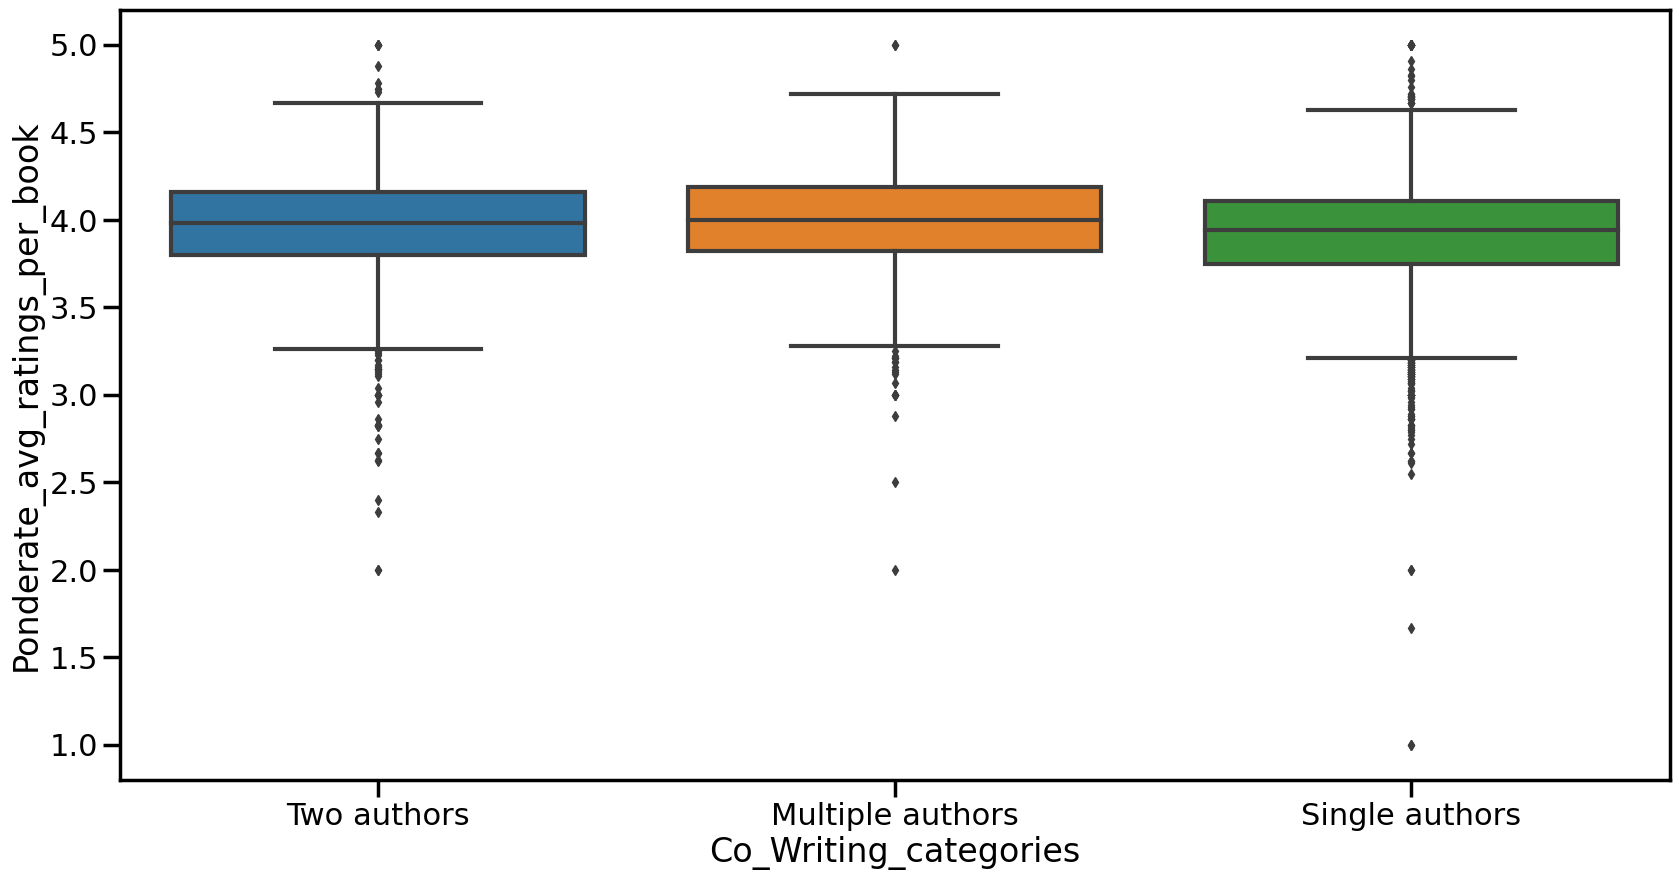

Co_Writing_categories
Multiple authors    3.993609
Two authors         3.964472
Single authors      3.917763
Name: Ponderate_avg_ratings_per_book, dtype: float64

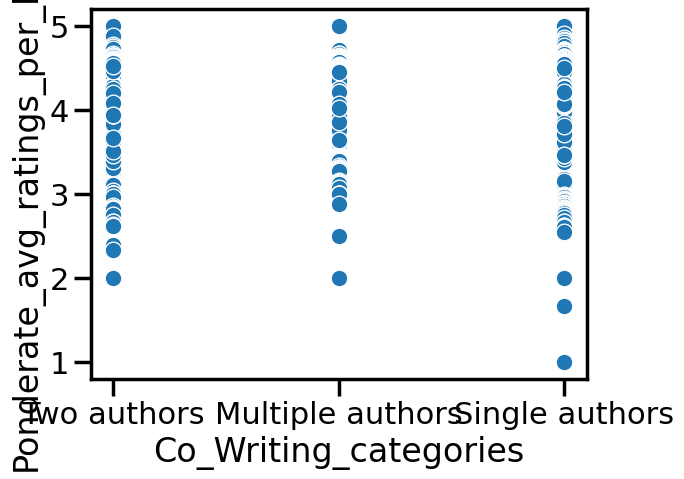

In [27]:
df_filtered['Co_Writing_categories'] = np.where(
    df_filtered['Num_authors'] == 1, 'Single authors', np.where(
    df_filtered['Num_authors'] == 2, 'Two authors', 'Multiple authors')) 


plt.figure(figsize=(20,10))
sns.boxplot(x=df_filtered.Co_Writing_categories,y=df_filtered.Ponderate_avg_ratings_per_book)
plt.show()

sns.scatterplot(data=df_filtered,x="Co_Writing_categories",y="Ponderate_avg_ratings_per_book")
df_filtered.Co_Writing_categories.value_counts() 
df_filtered.groupby(["Co_Writing_categories"]).mean(numeric_only=True).Ponderate_avg_ratings_per_book.sort_values(ascending=False)

#We don't see any significative impact on the average rating

In [22]:
df_filtered.publisher.value_counts()#Some publisher have a lto of books, some other only one --> Create a categorisation with the size ?

Vintage                             306
Penguin Books                       232
Penguin Classics                    154
Mariner Books                       142
Ballantine Books                    139
                                   ... 
Taplinger Publishing                  1
Waveland Press                        1
Collins Design                        1
Mestas Ediciones                      1
Teacher's Pet Publications  Inc.      1
Name: publisher, Length: 2126, dtype: int64

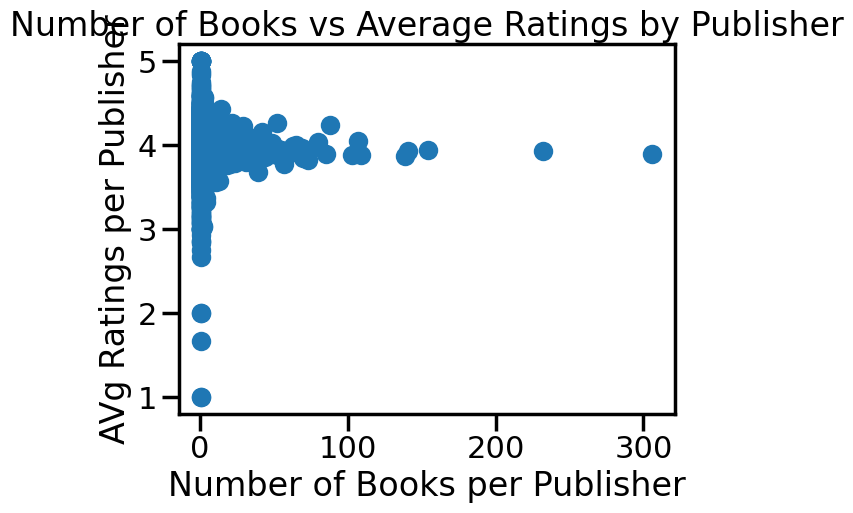

In [28]:
#creating a data frame with the number of book and the average rating per publisher to look for a correlation
publicount = pd.DataFrame(df_filtered.publisher.value_counts().values, index = df_filtered.publisher.value_counts().index )
publicount.rename(columns={ publicount.columns[0]: "BooksCount_Per_Publisher" }, inplace = True)
publicount = publicount.sort_index()

#Need to add this array to the previous data frame
publirating = pd.DataFrame(df_filtered.groupby(["publisher"]).mean(numeric_only=True).Ponderate_avg_ratings_per_book.values,df_filtered.groupby(["publisher"]).mean(numeric_only=True).Ponderate_avg_ratings_per_book.index)
publirating.rename(columns={ publirating.columns[0]: "Avg_ratings_Per_Publisher" }, inplace = True)

publicountrating = pd.DataFrame(publicount.loc[:,'BooksCount_Per_Publisher'], publicount.index)
publicountrating['Avg_ratings_Per_Publisher'] = publirating



publicount.describe() # we can see there is huge outliers, some publisher have a lots of books in the data set, there is a big std. We can see than 75% of 
#the publishers have 3 books or less in the data set. We will categorise those data between big and small publisher ? 
#We could as well look if the publisher already published a good book and use this as a dummy variable.

publirating.describe() # We could wonder if the size of the publisher has a link with the quality of the books they published.
#correlation between averageratings and numbers of books published.
publicount.head()
publirating.head()
publicountrating.head()


plt.scatter(publicountrating.loc[:, 'BooksCount_Per_Publisher'], publicountrating["Avg_ratings_Per_Publisher"])
plt.xlabel("Number of Books per Publisher")
plt.ylabel("AVg Ratings per Publisher")
plt.title("Number of Books vs Average Ratings by Publisher")
plt.show()
#We don't see any pattern here

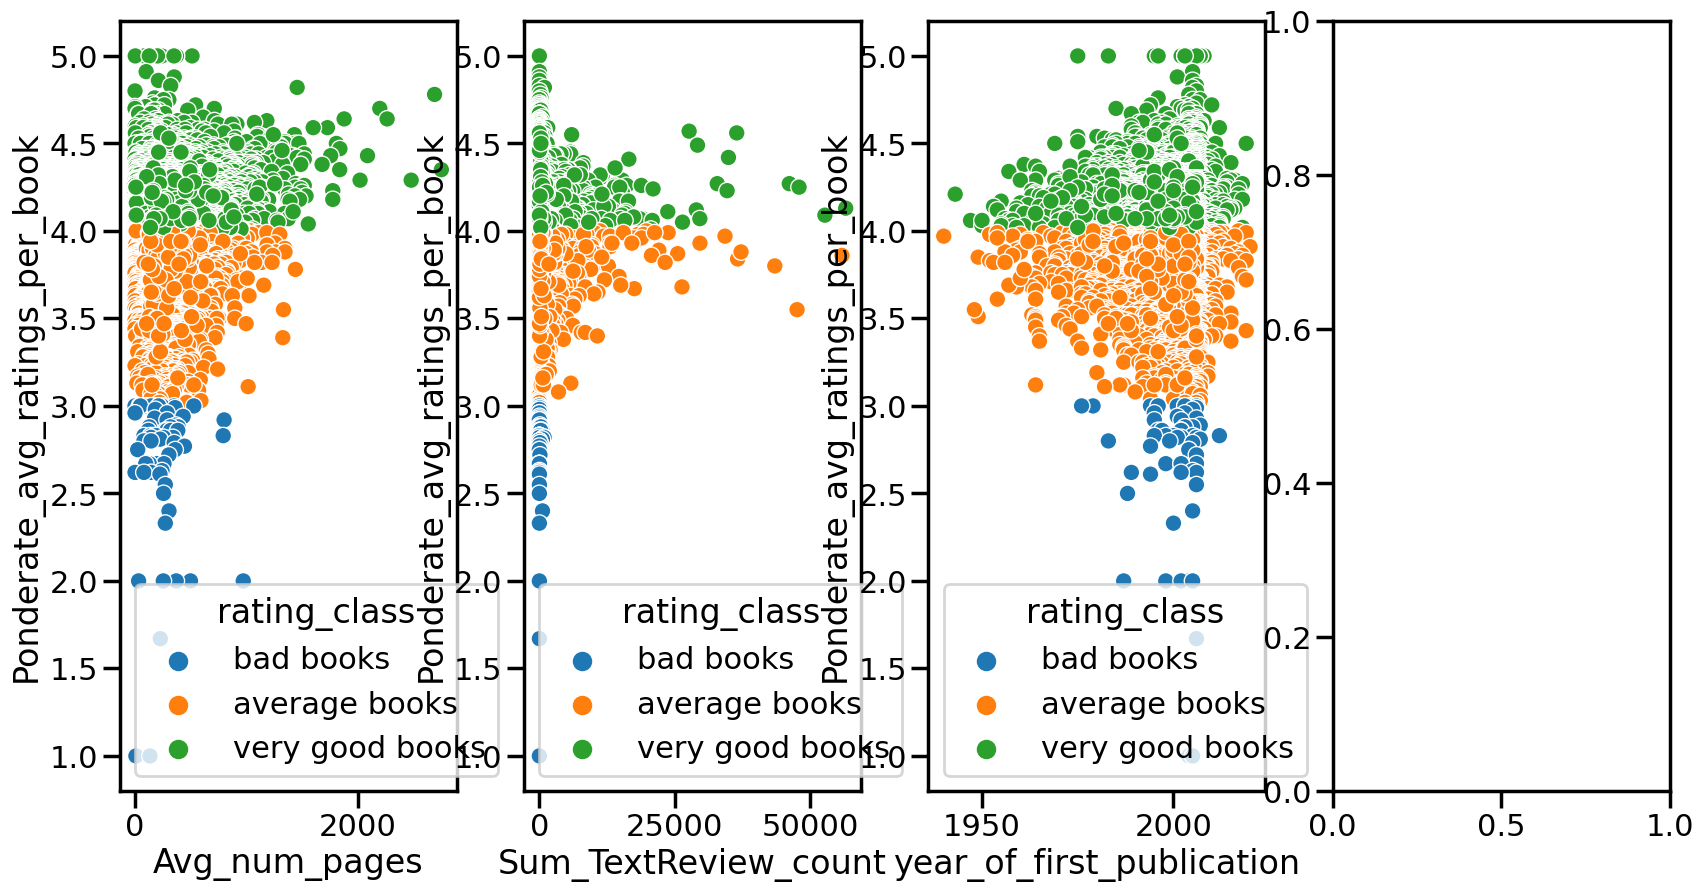

In [39]:
#Let's look at the relation between the target and the explanatory variables 

# Create a figure with subplots
fig, axs = plt.subplots(ncols=4, figsize=(20, 10))

# Select the target variable
target_var = 'Ponderate_avg_ratings_per_book'

# Select the explanatory variables
explanatory_vars = ['Avg_num_pages', 'Sum_TextReview_count', 'year_of_first_publication']

# Loop through each explanatory variable and create a scatter plot
for i, var in enumerate(explanatory_vars):
    sns.scatterplot(data=df_filtered, x=var, y=target_var, hue= "rating_class", ax=axs[i])

# Display the plot
plt.show()

#Seems like text review count, num pages and maybe year of publication can bring some information on the classification
#The results are not net though. It will be hard to discriminate between bad medium and good

In [113]:

df_filtered.head()

title  \
bookID                                                      
23552                         The New Big Book of America   
32823        Fanning the Flame: Bible  Cross  and Mission   
20957   Colossians and Philemon: A Critical and Exeget...   
17224   The Diamond Color Meditation: Color Pathway to...   
18184   The Complete Theory Fun Factory: Music Theory ...   

                                                 authors  average_rating  \
bookID                                                                     
23552                               Todd Davis/Marc Frey             5.0   
32823   Chris    Green/Chris Wright/Paul Douglas Gardner             5.0   
20957                                     R. McL. Wilson             5.0   
17224                                      John  Diamond             5.0   
18184                    Ian        Martin/Katie Elliott             5.0   

       language_code  num_pages  ratings_count  text_reviews_count  \
bookID                                                               
23552            eng         56              2                   1   
32823            eng        336              1                   1   
20957            eng        512              1                   0   
17224            eng         74              5                   3   
18184            eng         96              1                   0   

       publication_date              publisher  Occur  ...  Avg_num_pages  \
bookID                                                 ...                  
23552         3/21/2002          Courage Books      1  ...           56.0   
32823         6/17/2003              Zondervan      1  ...          336.0   
20957        12/07/2005        T&T Clark Int'l      1  ...          512.0   
17224         2/01/2006  Square One Publishers      1  ...           74.0   
18184         6/01/2004    Boosey & Hawkes Inc      1  ...           96.0   

        year  year_of_first_publication  Sum_Ratings_count  \
bookID                                                       
23552   2002                       2002                  2   
32823   2003                       2003                  1   
20957   2005                       2005                  1   
17224   2006                       2006                  5   
18184   2004                       2004                  1   

        Sum_TextReview_count  Ponderate_avg_ratings_per_row  \
bookID                                                        
23552                      1                            5.0   
32823                      1                            5.0   
20957                      0                            5.0   
17224                      3                            5.0   
18184                      0                            5.0   

        Ponderate_avg_ratings_per_book     rating_class PublisherOccur  \
bookID                                                                   
23552                              5.0  very good books              1   
32823                              5.0  very good books             13   
20957                              5.0  very good books              1   
17224                              5.0  very good books              1   
18184                              5.0  very good books              1   

        language_group  
bookID                  
23552              eng  
32823              eng  
20957              eng  
17224              eng  
18184              eng  

[5 rows x 21 columns]

In [40]:
#Final dataframe for our model

df_filtered.head()


# select columns 'name' and 'age' to create a subdataframe
final_df = df_filtered[['rating_class','Republished','Avg_num_pages', 
                        'year_of_first_publication', 'text_reviews_count']] #'language_group']]

final_df.describe()


Republished  Avg_num_pages  year_of_first_publication  \
count  10140.000000   10140.000000               10140.000000   
mean       0.047929     331.876923                2000.077712   
std        0.213627     219.489230                   7.897114   
min        0.000000       0.000000                1940.000000   
25%        0.000000     196.000000                1998.000000   
50%        0.000000     296.000000                2003.000000   
75%        0.000000     409.250000                2005.000000   
max        1.000000    2751.000000                2020.000000   

       text_reviews_count  
count        10140.000000  
mean           569.970710  
std           2377.766356  
min              0.000000  
25%             10.000000  
50%             53.000000  
75%            271.000000  
max          56604.000000

In [41]:

# Define a function to map rating_class names to number
def get_rating_class(rating_class):
    if rating_class == 'bad books':
        return 1
    elif rating_class == 'average books':
        return 2
    else:
        return 3

# Apply the function to create a new column based on the 'fruit' column
final_df['Book_rating'] = final_df['rating_class'].apply(get_rating_class)
final_df = final_df.drop(columns=['rating_class'])
print(final_df.Book_rating.value_counts())
final_df.head()

2    5774
3    4295
1      71
Name: Book_rating, dtype: int64


C:\Users\Ben\AppData\Local\Temp\ipykernel_3904\217142500.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Book_rating'] = final_df['rating_class'].apply(get_rating_class)


Republished  Avg_num_pages  year_of_first_publication  \
bookID                                                          
23552             0           56.0                       2002   
32823             0          336.0                       2003   
20957             0          512.0                       2005   
17224             0           74.0                       2006   
18184             0           96.0                       2004   

        text_reviews_count Book_rating  
bookID                                  
23552                    1           3  
32823                    1           3  
20957                    0           3  
17224                    3           3  
18184                    0           3

In [31]:
# Define a function to map language group to numbers
def get_rating_class(language_group):
    if language_group == 'eng':
        return 1
    elif language_group == 'spa':
        return 2
    elif language_group == 'fre':
        return 3
    else:
        return 4

# Apply the function to create a new column based on the 'fruit' column
final_df['language_cat'] = final_df['language_group'].apply(get_rating_class)
final_df = final_df.drop(columns=['language_group'])
print(final_df.language_cat.value_counts())
final_df.head()

1    9725
2     193
3     131
4      91
Name: language_cat, dtype: int64


Republished  Avg_num_pages  year_of_first_publication  \
bookID                                                          
23552             0           56.0                       2002   
32823             0          336.0                       2003   
20957             0          512.0                       2005   
17224             0           74.0                       2006   
18184             0           96.0                       2004   

        text_reviews_count Book_rating  language_cat  
bookID                                                
23552                    1           3             1  
32823                    1           3             1  
20957                    0           3             1  
17224                    3           3             1  
18184                    0           3             1

In [42]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('Book_rating', axis=1), final_df['Book_rating'], test_size=0.2)

y_train.value_counts()

2    4614
3    3438
1      60
Name: Book_rating, dtype: int64

In [43]:
#RANDOM FOREST
# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(final_df.drop('Book_rating', axis=1), final_df['Book_rating'], test_size=0.2)

# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = rf.predict(X_test)
#y_pred = np.round(y_pred).astype(int)


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall and F1 score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confusion_mat)


Accuracy: 0.571992110453649
Precision: [0.         0.61140285 0.49855491]
Recall: [0.         0.70258621 0.40256709]
F1 score: [0.         0.65383073 0.44544868]
Confusion matrix:
 [[  0   7   4]
 [  2 815 343]
 [  1 511 345]]


In [44]:
#LOGISTIC
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('Book_rating', axis=1), final_df['Book_rating'], test_size=0.2)

# Create a logistic regression model
lr = LogisticRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall and F1 score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confusion_mat)

Accuracy: 0.6084812623274162
Precision: [0.         0.5978924  0.69333333]
Recall: [0.         0.93984307 0.18055556]
F1 score: [0.         0.73084746 0.28650138]
Confusion matrix:
 [[   0   17    0]
 [   0 1078   69]
 [   0  708  156]]


C:\Users\Ben\Anaconda3\envs\goodreads\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
#Oversampling the category Bad book


# Define your target variable and the features to use for training
target_variable = 'Book_rating'
features = ['Republished','Avg_num_pages','year_of_first_publication', 'text_reviews_count']#, 'language_cat']

# Separate the target variable and the features from the DataFrame
X = X_train[features]
y = y_train#[target_variable]

# Split the data into training and testing sets (if necessary)
# train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the SMOTE function with the desired sampling strategy
sm = SMOTE(sampling_strategy={1:1500})

# Apply SMOTE to oversample the minority class
X_train_resampled, y_train_resampled = sm.fit_resample(X, y)

# Check the new class distribution
print(y_train_resampled.value_counts())

2    4627
3    3431
1    1500
Name: Book_rating, dtype: int64


In [47]:
#Rqndom forest resampled
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100)

# Fit the model on the training data
rf.fit(X_train_resampled, y_train_resampled)

# Use the model to make predictions on the test data
y_pred = rf.predict(X_test)
#y_pred = np.round(y_pred).astype(int)


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall and F1 score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confusion_mat)


Accuracy: 0.5409270216962525
Precision: [0.04109589 0.6001609  0.48876404]
Recall: [0.17647059 0.65039233 0.40277778]
F1 score: [0.06666667 0.62426778 0.44162437]
Confusion matrix:
 [[  3   8   6]
 [ 43 746 358]
 [ 27 489 348]]


In [48]:
#LOGISTIC resampled
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('Book_rating', axis=1), final_df['Book_rating'], test_size=0.2)

# Create a logistic regression model
lr = LogisticRegression()

# Fit the model on the training data
lr.fit(X_train_resampled, y_train_resampled)

# Use the model to make predictions on the test data
y_pred = lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall and F1 score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confusion_mat)

Accuracy: 0.5922090729783037
Precision: [0.         0.58732782 0.63380282]
Recall: [0.         0.93263342 0.15446224]
F1 score: [0.         0.72075727 0.24839006]
Confusion matrix:
 [[   0   10    1]
 [   0 1066   77]
 [   0  739  135]]


C:\Users\Ben\Anaconda3\envs\goodreads\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
#Oversampling the category Bad book


# Define your target variable and the features to use for training
target_variable = 'Book_rating'
features = ['Republished','Avg_num_pages','year_of_first_publication', 'text_reviews_count']#, 'language_cat']

# Separate the target variable and the features from the DataFrame
X = X_train[features]
y = y_train#[target_variable]

# Split the data into training and testing sets (if necessary)
# train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the SMOTE function with the desired sampling strategy
sm = SMOTE(sampling_strategy={1:3000})

# Apply SMOTE to oversample the minority class
X_train_resampled, y_train_resampled = sm.fit_resample(X, y)

# Check the new class distribution
print(y_train_resampled.value_counts())

2    4631
3    3421
1    3000
Name: Book_rating, dtype: int64


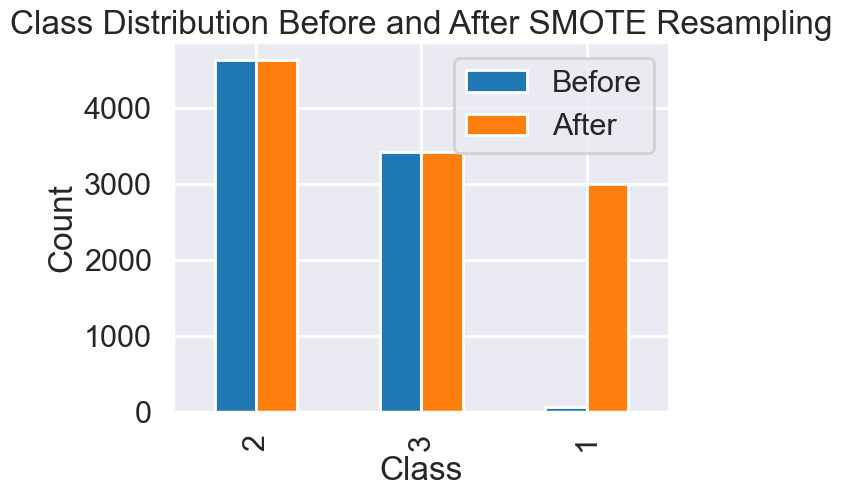

In [51]:
# Calculate the count of samples for each class in the original dataset
counts_before = y_train.value_counts()

# Calculate the count of samples for each class in the resampled dataset
counts_after = y_train_resampled.value_counts()

# Combine the counts into a single DataFrame
counts = pd.concat([counts_before, counts_after], axis=1)
counts.columns = ['Before', 'After']

# Plot the counts using a bar plot
sns.set_style('darkgrid')
counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Before and After SMOTE Resampling')
plt.show()

In [52]:
# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100)

# Fit the model on the training data
rf.fit(X_train_resampled, y_train_resampled)

# Use the model to make predictions on the test data
y_pred = rf.predict(X_test)
#y_pred = np.round(y_pred).astype(int)

# Calculate the accuracy of the model on the test data


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall and F1 score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confusion_mat)


Accuracy: 0.5458579881656804
Precision: [0.         0.60771165 0.50865513]
Recall: [0.         0.63429571 0.43707094]
F1 score: [0.         0.62071918 0.47015385]
Confusion matrix:
 [[  0   8   3]
 [ 52 725 366]
 [ 32 460 382]]
